# setup

In [5]:
import aiohttp
import json
import os

import matplotlib.pyplot as plt
import nest_asyncio
from tqdm.notebook import tqdm

## change these parameters

In [49]:
NUM_KIDS = 100 # per story

# json's
HN_STORIES_JSON = '../../data/hn_stories_dataset_final.json' # contains the raw fetched hn stories and comment ids
HN_STORIES_GH_JSON = '../../data/hn_stories_dataset_gh_final.json'

# csv's
HN_STORIES_CSV = '../../data/hn_stories_dataset_final.csv' # after converting raw json to raw csv
HN_STORIES_GH_CSV = '../../data/hn_stories_dataset_gh_final.csv' # after converting raw json to raw csv

# txt's
KEYWORDS_TXT = 'ai_keywords.txt' # used to match relevant hn stories titles
HN_GITHUB_URLS_TXT = 'hn_github_urls.txt'

# Define the base URL for the Hacker News API
BASE_URL = 'https://hacker-news.firebaseio.com/v0'

# hackernews stories id's
CHATGPT_RELEASE_ID = 33804874 # nov 30th 2022
START_ID = 31300000 # may 8th 2022
END_ID = 40300000 # may 9th 2024

# dataset retrieval parameters
INCREMENT = 1 # 1: fetch every stories, 2: skip every other stories, 3: skip every 2 stories, etc.
DEPTH = 3 # comments depth, minimum as 1

In [5]:
# setup async
nest_asyncio.apply()

In [6]:
# test that calling hackernews api works
async with aiohttp.ClientSession() as session:
    async with session.get(f'{BASE_URL}/topstories.json') as response:
        print(await response.json())

[41564003, 41563626, 41562673, 41562633, 41563958, 41563621, 41562287, 41556519, 41560343, 41561647, 41563363, 41558554, 41522814, 41546619, 41558081, 41518698, 41564009, 41563746, 41562481, 41563100, 41533207, 41562034, 41562774, 41562981, 41547378, 41557345, 41529709, 41560648, 41557851, 41560659, 41542409, 41549649, 41547008, 41530040, 41563238, 41519046, 41554791, 41554177, 41557030, 41557107, 41559761, 41546803, 41551084, 41562846, 41545810, 41554157, 41562170, 41563709, 41562076, 41561965, 41543805, 41562632, 41558800, 41550603, 41562904, 41519229, 41553689, 41560359, 41528919, 41519409, 41550364, 41548663, 41562713, 41550017, 41529415, 41547841, 41550417, 41547395, 41562394, 41543666, 41552804, 41545100, 41530783, 41554899, 41564604, 41556378, 41561703, 41547181, 41562553, 41557383, 41543386, 41546015, 41543642, 41545737, 41558951, 41548058, 41556844, 41563781, 41555349, 41533387, 41562750, 41539288, 41550262, 41544969, 41540950, 41530571, 41557588, 41547773, 41536167, 41553727,

# fetch and structure the dataset

In [7]:
# retrieve keywords from ai_keywords.txt
keywords = []
with open(KEYWORDS_TXT, 'r') as f:
    keywords = [keyword.strip() for keyword in f.readlines()]
    print(keywords)

['Artificial Intelligence', 'AI', 'Natural Language Processing', 'NLP', 'Language Model', 'LLM', 'Chatbot', 'ChatGPT', 'OpenAI', 'Claude', 'Llama', 'Gemini', 'Gemma', 'Mistral', 'Cohere']


## hackernews methods setup

In [6]:
import re

async def get_top_story_ids(session):
    async with session.get(f'{BASE_URL}/topstories.json') as response:
        return await response.json()

async def get_item(session, item_id):
    async with session.get(f'{BASE_URL}/item/{item_id}.json') as response:
        return await response.json()

def load_progress(dataset_json_filename):
    if os.path.exists(dataset_json_filename):
        with open(dataset_json_filename, 'r') as f:
            return json.load(f)
    return {'processed_story_max_id': -1, 'stories': []}

def save_progress(data, dataset_json_filename):
    with open(dataset_json_filename, 'w') as f:
        json.dump(data, f, indent=4)

async def search_stories(dataset_json_filename, start_id, end_id):
    progress = load_progress(dataset_json_filename)
    progress_story_max_id = progress['processed_story_max_id']
    stories = progress['stories']

    async with aiohttp.ClientSession() as session:
        if progress_story_max_id < 0:
            # Starting from the specified story id until we reached the required quantity
            story_id = start_id
        else:
            # otherwise, start from the last processed story
            story_id = progress_story_max_id

        pbar = tqdm(total=end_id-start_id, desc="Fetching stories")
        pbar.update(story_id-start_id)

        # main loop
        increment = INCREMENT
        while story_id < end_id:
            try:
                # check whether we already retrieved title
                if story_id <= progress_story_max_id:
                    story_id += increment
                    pbar.update(increment)
                    continue

                # get story
                story = await get_item(session, story_id)

                # check whether story exists, if not then skip next time
                if not story or 'title' not in story:
                    story_id += increment
                    progress_story_max_id = story_id
                    pbar.update(increment)
                    continue

                # Minimum score of 20 to ensure that there's enough discussions going on
                if story['score'] < 20:
                    story_id += increment
                    progress_story_max_id = story_id
                    pbar.update(increment)
                    continue

                # check if the story title contains keyword
                title_lower = story['title'].lower()
                for keyword in keywords:
                    pattern = r'\b' + re.escape(keyword.lower()) + r'\b'

                    if re.search(pattern, title_lower):
                        # add to stories
                        stories.append(story)
                        break
                story_id += increment
                progress_story_max_id = story_id
                pbar.update(increment)

                # save progress periodically
                progress['processed_story_max_id'] = progress_story_max_id
                progress['stories'] = stories
                save_progress(progress, dataset_json_filename)

            except Exception as e:
                # Save progress before exiting due to error
                print(f"Error processing story {story_id}: {e}")
                progress['processed_story_max_id'] = progress_story_max_id
                progress['stories'] = stories
                save_progress(progress, dataset_json_filename)
        pbar.close()
    return stories

## running

In [ ]:
try:
    stories_chatgpt = await search_stories(dataset_json_filename=HN_STORIES_JSON, start_id=START_ID, end_id=END_ID)
    print(f'Found {len(stories_chatgpt)} hn stories')
except Exception as e:
    print(f"An error occurred: {e}")

# count stories/comments in the dataset

In [15]:
def analyze_data(dataset_json_filename):
    with open(dataset_json_filename, 'r') as f:
        data = json.load(f)

    total_stories = len(data['stories'])
    total_kids = sum(len(story.get('kids', [])) for story in data['stories'])

    print(f"====== File: {dataset_json_filename} ==")
    print(f"Stories found: {total_stories}")
    print(f"Total comments (kids): {total_kids}")


In [16]:
analyze_data(HN_STORIES_JSON)
analyze_data(HN_STORIES_GH_JSON)

====== File: ../../data/hn_stories_dataset_final.json ==
Stories found: 4645
Total comments (kids): 82250
====== File: ../../data/hn_stories_dataset_gh_final.json ==
Stories found: 354
Total comments (kids): 4707


# visualize comment distribution

In [29]:
def visualize_comment_distribution(progress_filename):
    with open(progress_filename, 'r') as f:
        data = json.load(f)

    stories = data['stories']
    total_stories = len(stories)
    total_kids = sum(len(story.get('kids', [])) for story in stories)

    # Calculate comments per story
    comments_per_story = [len(story.get('kids', [])) for story in stories]

    # Create histogram
    plt.figure(figsize=(12, 6))
    plt.hist(comments_per_story, bins=30, edgecolor='black')
    plt.title('Distribution of Comments per Story')
    plt.xlabel('Number of Comments')
    plt.ylabel('Number of Stories')

    # Add mean line
    mean_comments = sum(comments_per_story) / len(comments_per_story)
    plt.axvline(mean_comments, color='r', linestyle='dashed', linewidth=2)
    plt.text(mean_comments*1.1, plt.ylim()[1]*0.9, f'Mean comments per story: {mean_comments:.2f}', color='r')

    # Add some stats as text
    stats_text = f'Total Stories: {total_stories}\nTotal Comments: {total_kids}\nMean Comments per Story: {mean_comments:.2f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
    plt.plot()

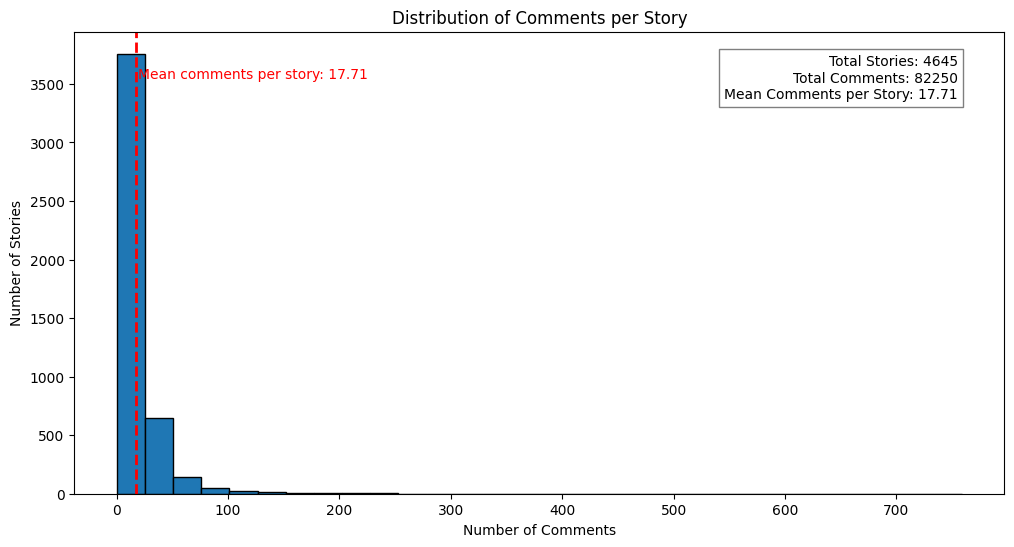

In [30]:
# Analyze the data
visualize_comment_distribution(HN_STORIES_JSON)

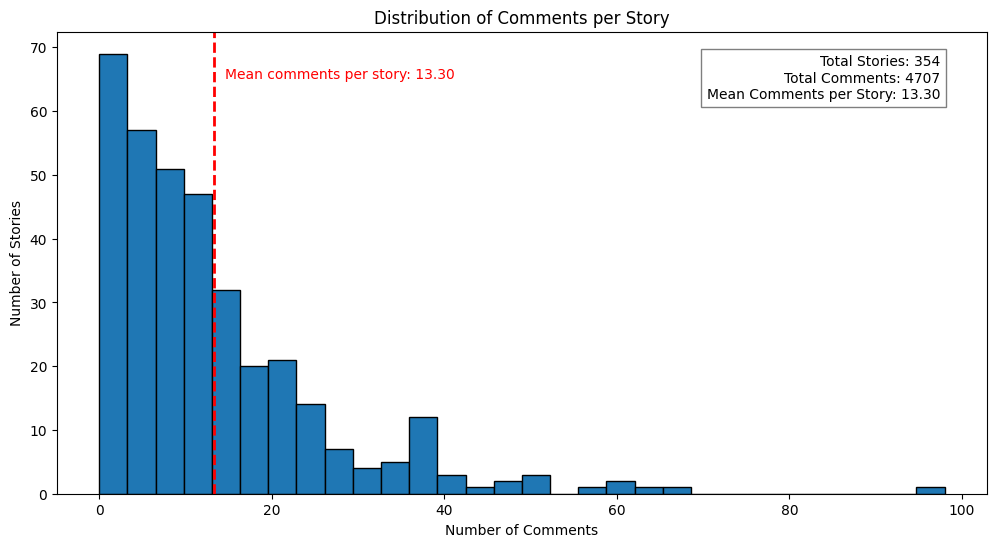

In [31]:
visualize_comment_distribution(HN_STORIES_GH_JSON)

# Filter for stories containing github URLs

In [11]:
import json

def filter_github_stories(data):
    github_stories = []

    # Loop through each story and check if the URL contains 'github.com'
    for story in data.get('stories', []):
        url = story.get('url', '')
        if 'github.com' in url:
            github_stories.append(story)

    return github_stories

Filtered stories saved to ../hn_stories_dataset_final_githubproj.json


In [ ]:
with open(HN_STORIES_JSON, 'r') as file:
    data = json.load(file)

# Filter the stories that have GitHub URLs
gh_stories = filter_github_stories(data)

# Prepare the output JSON structure
output_structure = {
    "processed_story_max_id": data.get("processed_story_max_id"),
    "stories": gh_stories
}

# Write the filtered stories to a new JSON file
with open(HN_STORIES_GH_JSON, 'w') as file:
    json.dump(output_structure, file, indent=4)

print(f"Filtered stories saved to {HN_STORIES_GH_JSON}")

# convert json to csv

## setup methods

In [54]:
from datetime import datetime
import csv
import random
import re
from bs4 import BeautifulSoup

def read_json_file(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def extract_github_urls(text):
    github_url_pattern = r"https://github\.com/[a-zA-Z0-9-]+/[a-zA-Z0-9-_.]+(?:/(?:issues|pull)/\d+)?"
    return list(set(re.findall(github_url_pattern, text)))

def unix_to_datetime(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp)

def clean_html(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    return soup.get_text(separator=' ', strip=True)

def process_stories(posts):
    rows = []

    for post in posts:
        post_id = post.get('id')
        title = post.get('title', '')
        url = post.get('url', '')
        date = (post.get('time', 0))

        rows.append({
            'discussion_id': post_id,
            'title': title,
            'url': url,
            'date': date,
        })

    return rows

def write_csv(filename, data, fieldnames):
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

## for all discussions

In [55]:
hn_stories_data = read_json_file(HN_STORIES_JSON)
print(f"ChatGPT stories: {len(hn_stories_data['stories'])}")

chatgpt_rows = process_stories(hn_stories_data['stories'])
print(f"Total rows: {len(chatgpt_rows)}")

# # Write to CSV files
fieldnames = ['discussion_id', 'title', 'url', 'date', ]

# # Write raw dataset
write_csv(HN_STORIES_CSV, chatgpt_rows, fieldnames)

print('done.')

ChatGPT stories: 4645
Total rows: 4645
done.


## for github-only

In [56]:
hn_stories_data = read_json_file(HN_STORIES_GH_JSON)
print(f"ChatGPT stories: {len(hn_stories_data['stories'])}")

chatgpt_rows = process_stories(hn_stories_data['stories'])
print(f"Total rows: {len(chatgpt_rows)}")

# # Write to CSV files
fieldnames = ['discussion_id', 'title', 'url', 'date', ]

# # Write raw dataset
write_csv(HN_STORIES_GH_CSV, chatgpt_rows, fieldnames)

print('done.')

ChatGPT stories: 354
Total rows: 354
done.


# graphing

## graphing total hackernews stories over time

### setup method

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def plot_discussions_histogram(title, csv_file_path, bin_size_days=7):
    """
    Plot a histogram of AI discussions over time from a CSV file.

    Args:
    title (str): graph title
    csv_file_path (str): The path to the CSV file.
    bin_size (str): The size of each bin. Use pandas frequency strings:
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Create the histogram
    fig, ax = plt.subplots(figsize=(15, 7))

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-9').timestamp()

    # Based on the start_id and end_id defined above
    total_days = (end_date - start_date) / (24*60*60)
    bins = int(total_days / bin_size_days)

    n, bins, patches = ax.hist(df['date'], bins=bins, range=(start_date, end_date), edgecolor='black')

    # Format x-axis ticks as dates
    def timestamp_to_date(timestamp):
        return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

    num_ticks = 5
    tick_locations = np.linspace(start_date, end_date, num_ticks)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels([timestamp_to_date(t) for t in tick_locations])

    plt.title(f'{title} (Bin Size: {bin_size_days} days)')
    plt.xlabel('Date')
    plt.ylabel('Number of Discussions')
    plt.xticks(rotation=45)

    # Add vertical line for ChatGPT release
    chatgpt_release = pd.Timestamp('2022-11-30').timestamp()
    plt.axvline(x=chatgpt_release, color='r', linestyle='--', label='ChatGPT Release')
    plt.legend()

    plt.tight_layout()
    # plt.savefig(f'hackernews_overall_trends_{bin_size_days}.png')
    plt.show()

### graphing raw hackernews stories dataset

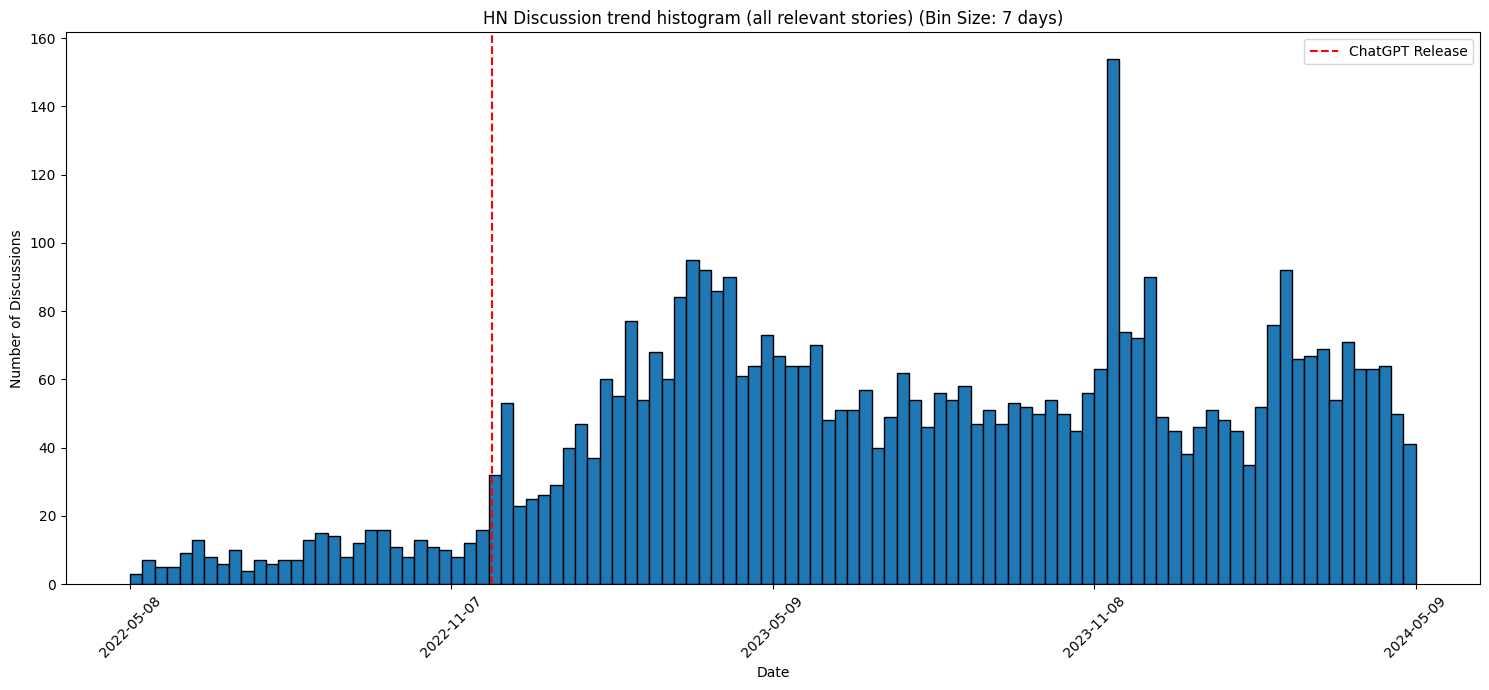

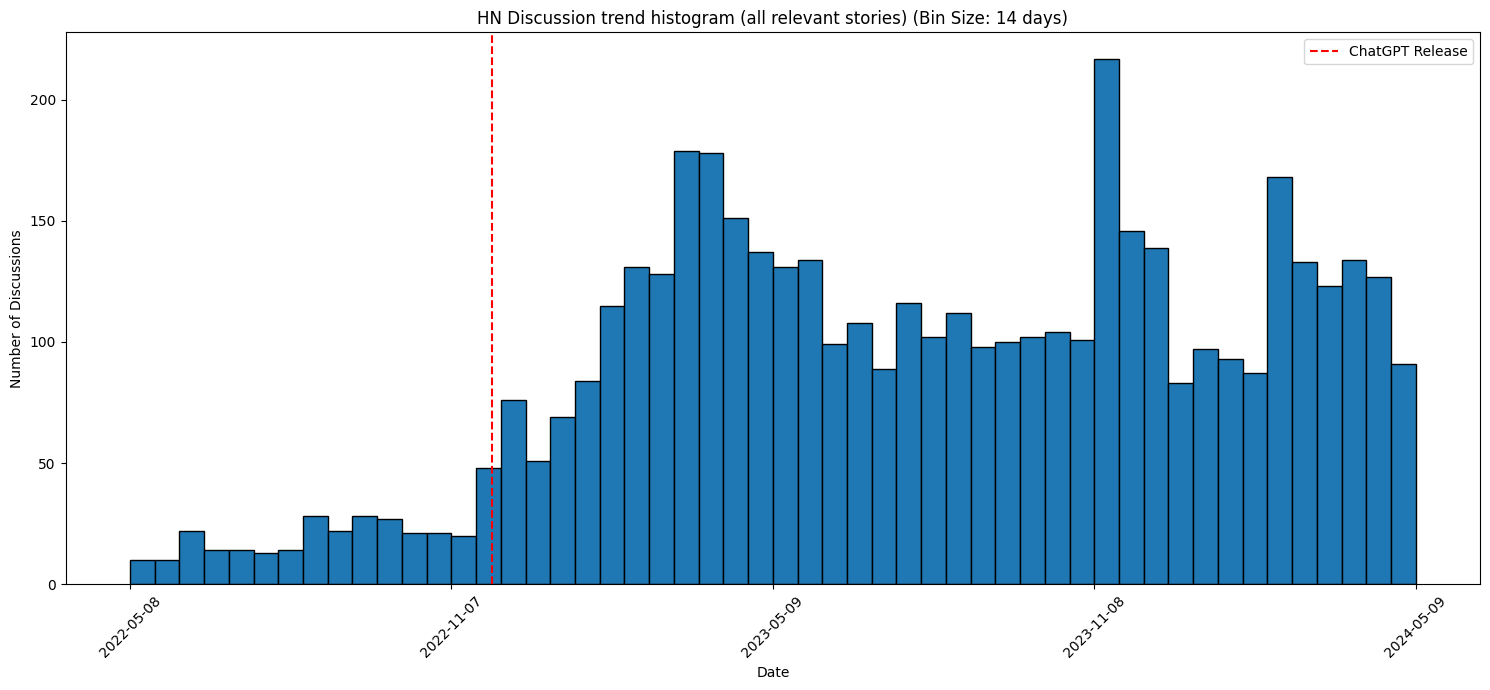

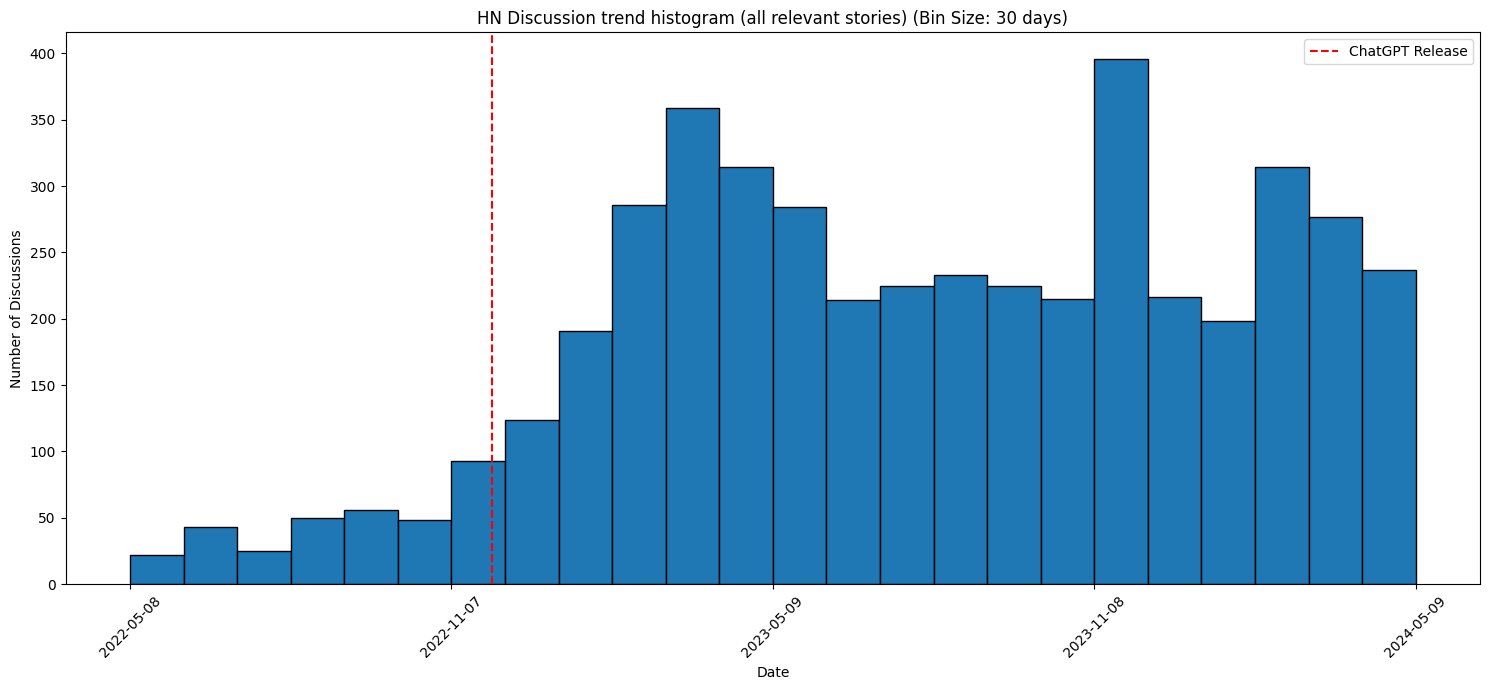

In [61]:
plot_discussions_histogram('HN Discussion trend histogram (all relevant stories)', HN_STORIES_CSV, bin_size_days=7)
plot_discussions_histogram('HN Discussion trend histogram (all relevant stories)', HN_STORIES_CSV, bin_size_days=14)
plot_discussions_histogram('HN Discussion trend histogram (all relevant stories)', HN_STORIES_CSV, bin_size_days=30)

### graphing github-only hackernews dataset

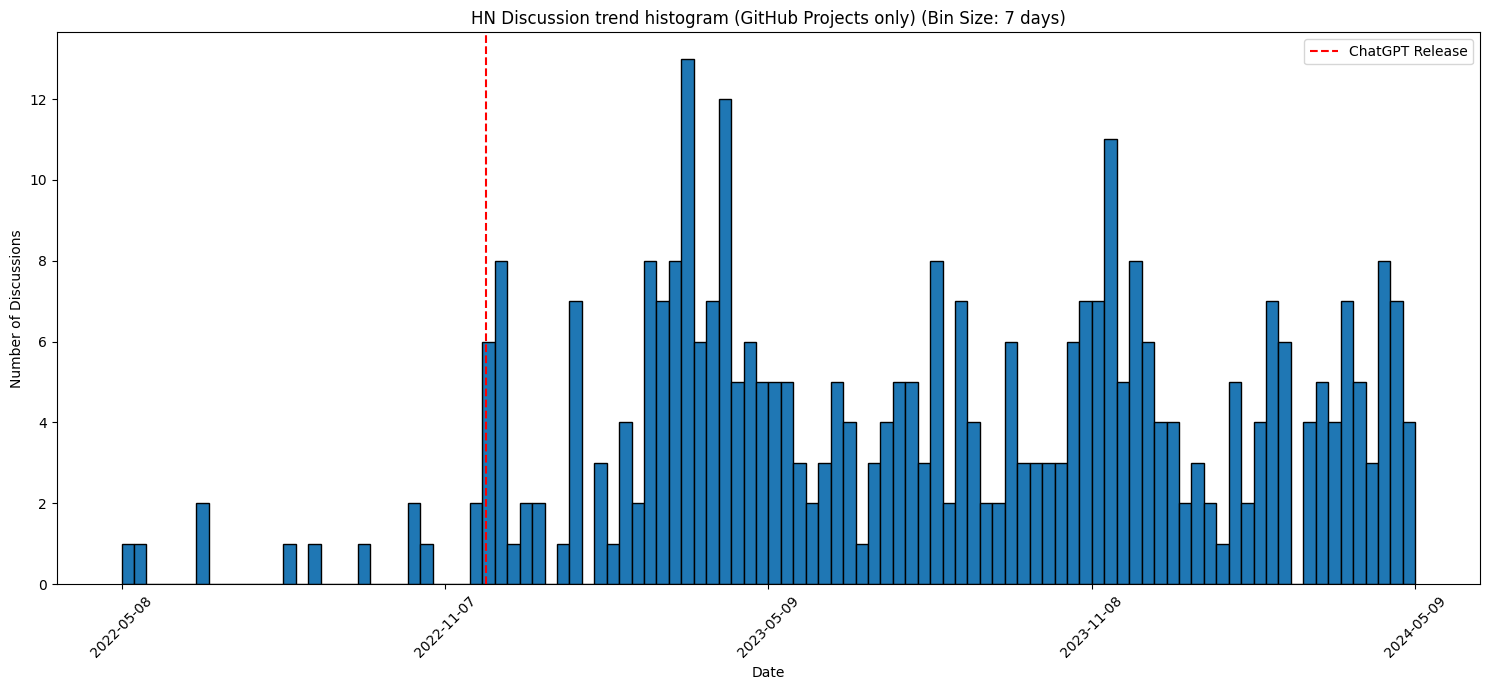

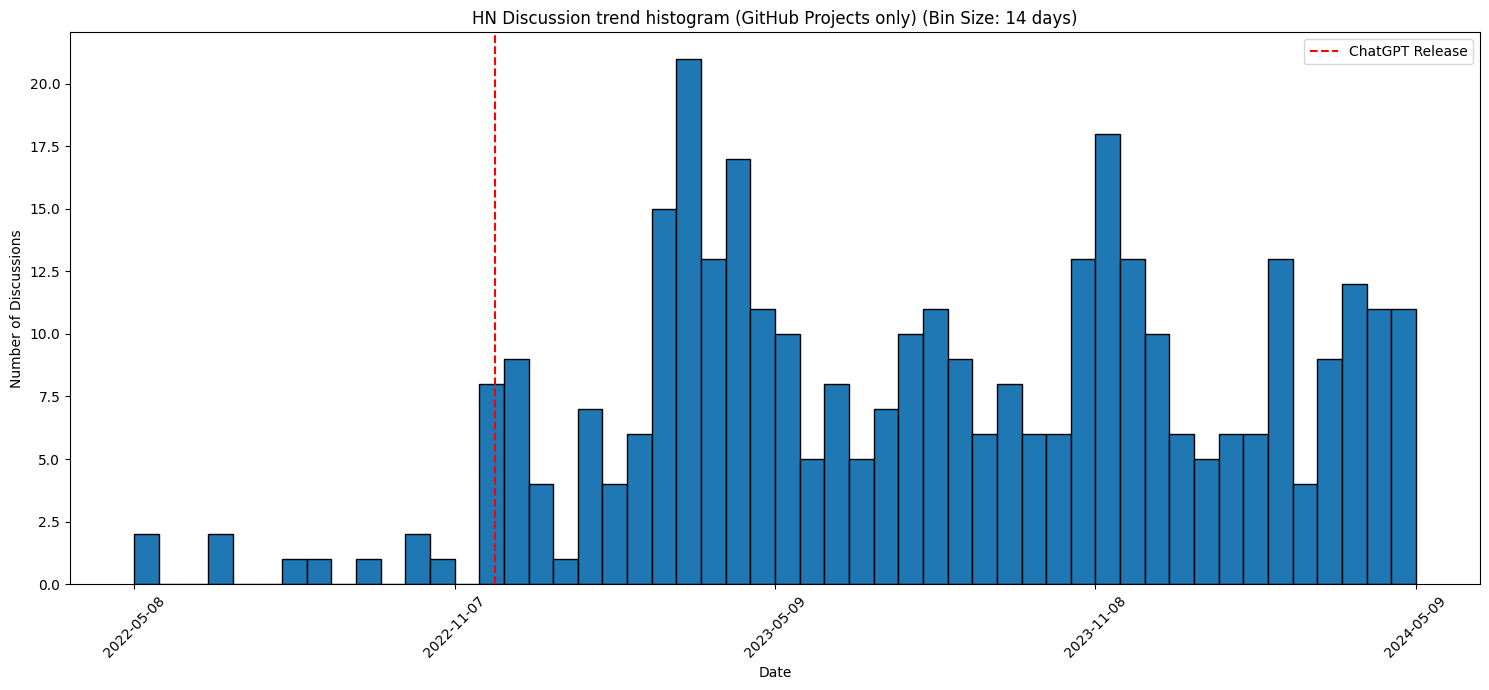

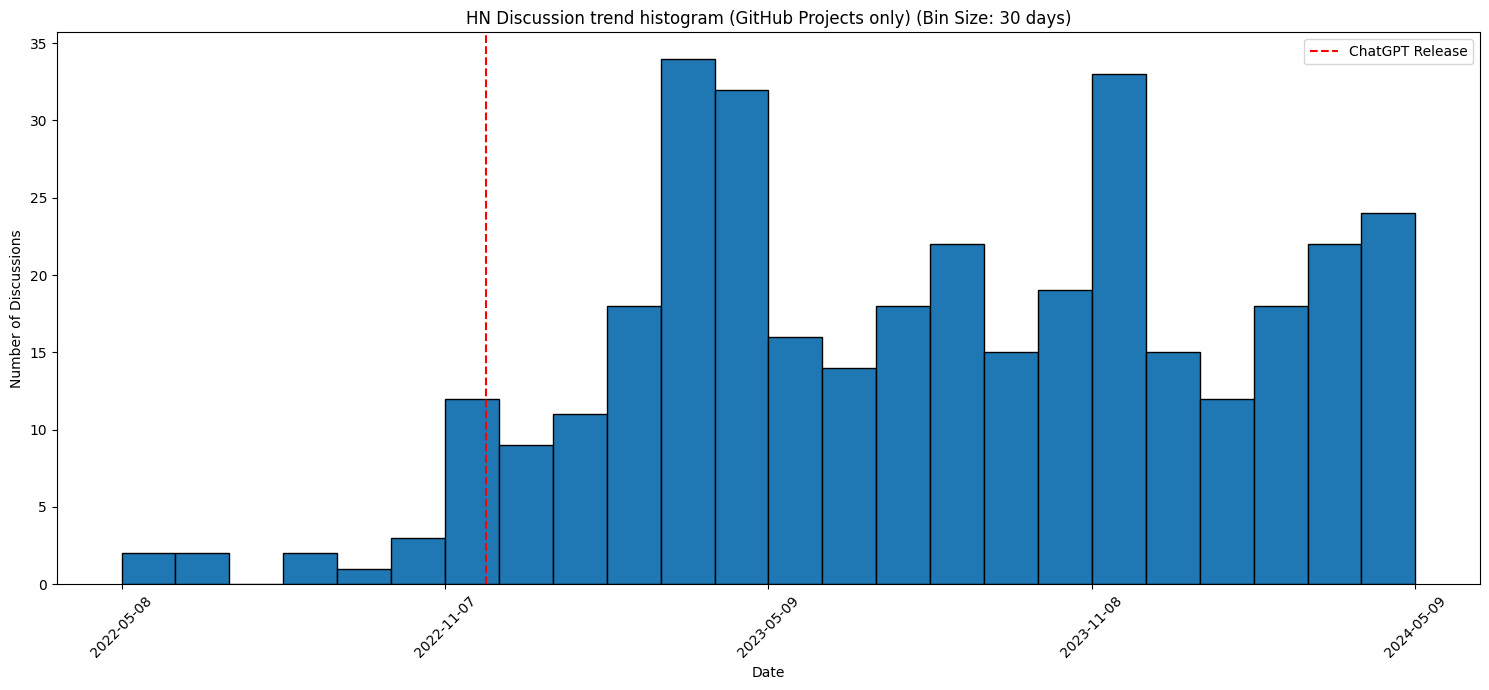

In [62]:
plot_discussions_histogram('HN Discussion trend histogram (GitHub Projects only)', HN_STORIES_GH_CSV, bin_size_days=7)
plot_discussions_histogram('HN Discussion trend histogram (GitHub Projects only)', HN_STORIES_GH_CSV, bin_size_days=14)
plot_discussions_histogram('HN Discussion trend histogram (GitHub Projects only)', HN_STORIES_GH_CSV, bin_size_days=30)

## graphing by keywords

### setup

In [65]:
import re

def plot_discussions_histogram_keywords(title, csv_file_path, keyword):
    """
    Plot histograms of AI discussions over time from a CSV file with three different bin sizes.

    Args:
    title (str): The graphs' titles
    csv_file_path (str): The path to the CSV file.
    keyword (str): The keyword to search for in the title column.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Filter the dataframe based on the keyword
    df = df[df['title'].str.contains(keyword, case=False, regex=True)]

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-09').timestamp()

    # Create the figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 21))

    bin_sizes = [7, 14, 30]
    axes = [ax1, ax2, ax3]

    for ax, bin_size_days in zip(axes, bin_sizes):
        # Calculate number of bins
        total_days = (end_date - start_date) / (24*60*60)
        bins = int(total_days / bin_size_days)

        # Create the histogram
        n, bins, patches = ax.hist(df['date'], bins=bins, range=(start_date, end_date), edgecolor='black')

        # Format x-axis ticks as dates
        def timestamp_to_date(timestamp):
            return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

        num_ticks = 5
        tick_locations = np.linspace(start_date, end_date, num_ticks)
        ax.set_xticks(tick_locations)
        ax.set_xticklabels([timestamp_to_date(t) for t in tick_locations])

        ax.set_title(f'Bin Size: {bin_size_days} days')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Discussions')
        ax.tick_params(axis='x', rotation=45)

        # Add vertical line for ChatGPT release
        chatgpt_release = pd.Timestamp('2022-11-30').timestamp()
        ax.axvline(x=chatgpt_release, color='r', linestyle='--', label='ChatGPT Release')
        ax.legend()

    plt.suptitle(f'{title} Keyword: {keyword}', fontsize=16, y=1.005)
    plt.tight_layout()
    # plt.savefig(f'hackernews_keyword_trends_{keyword}.png')
    plt.show()

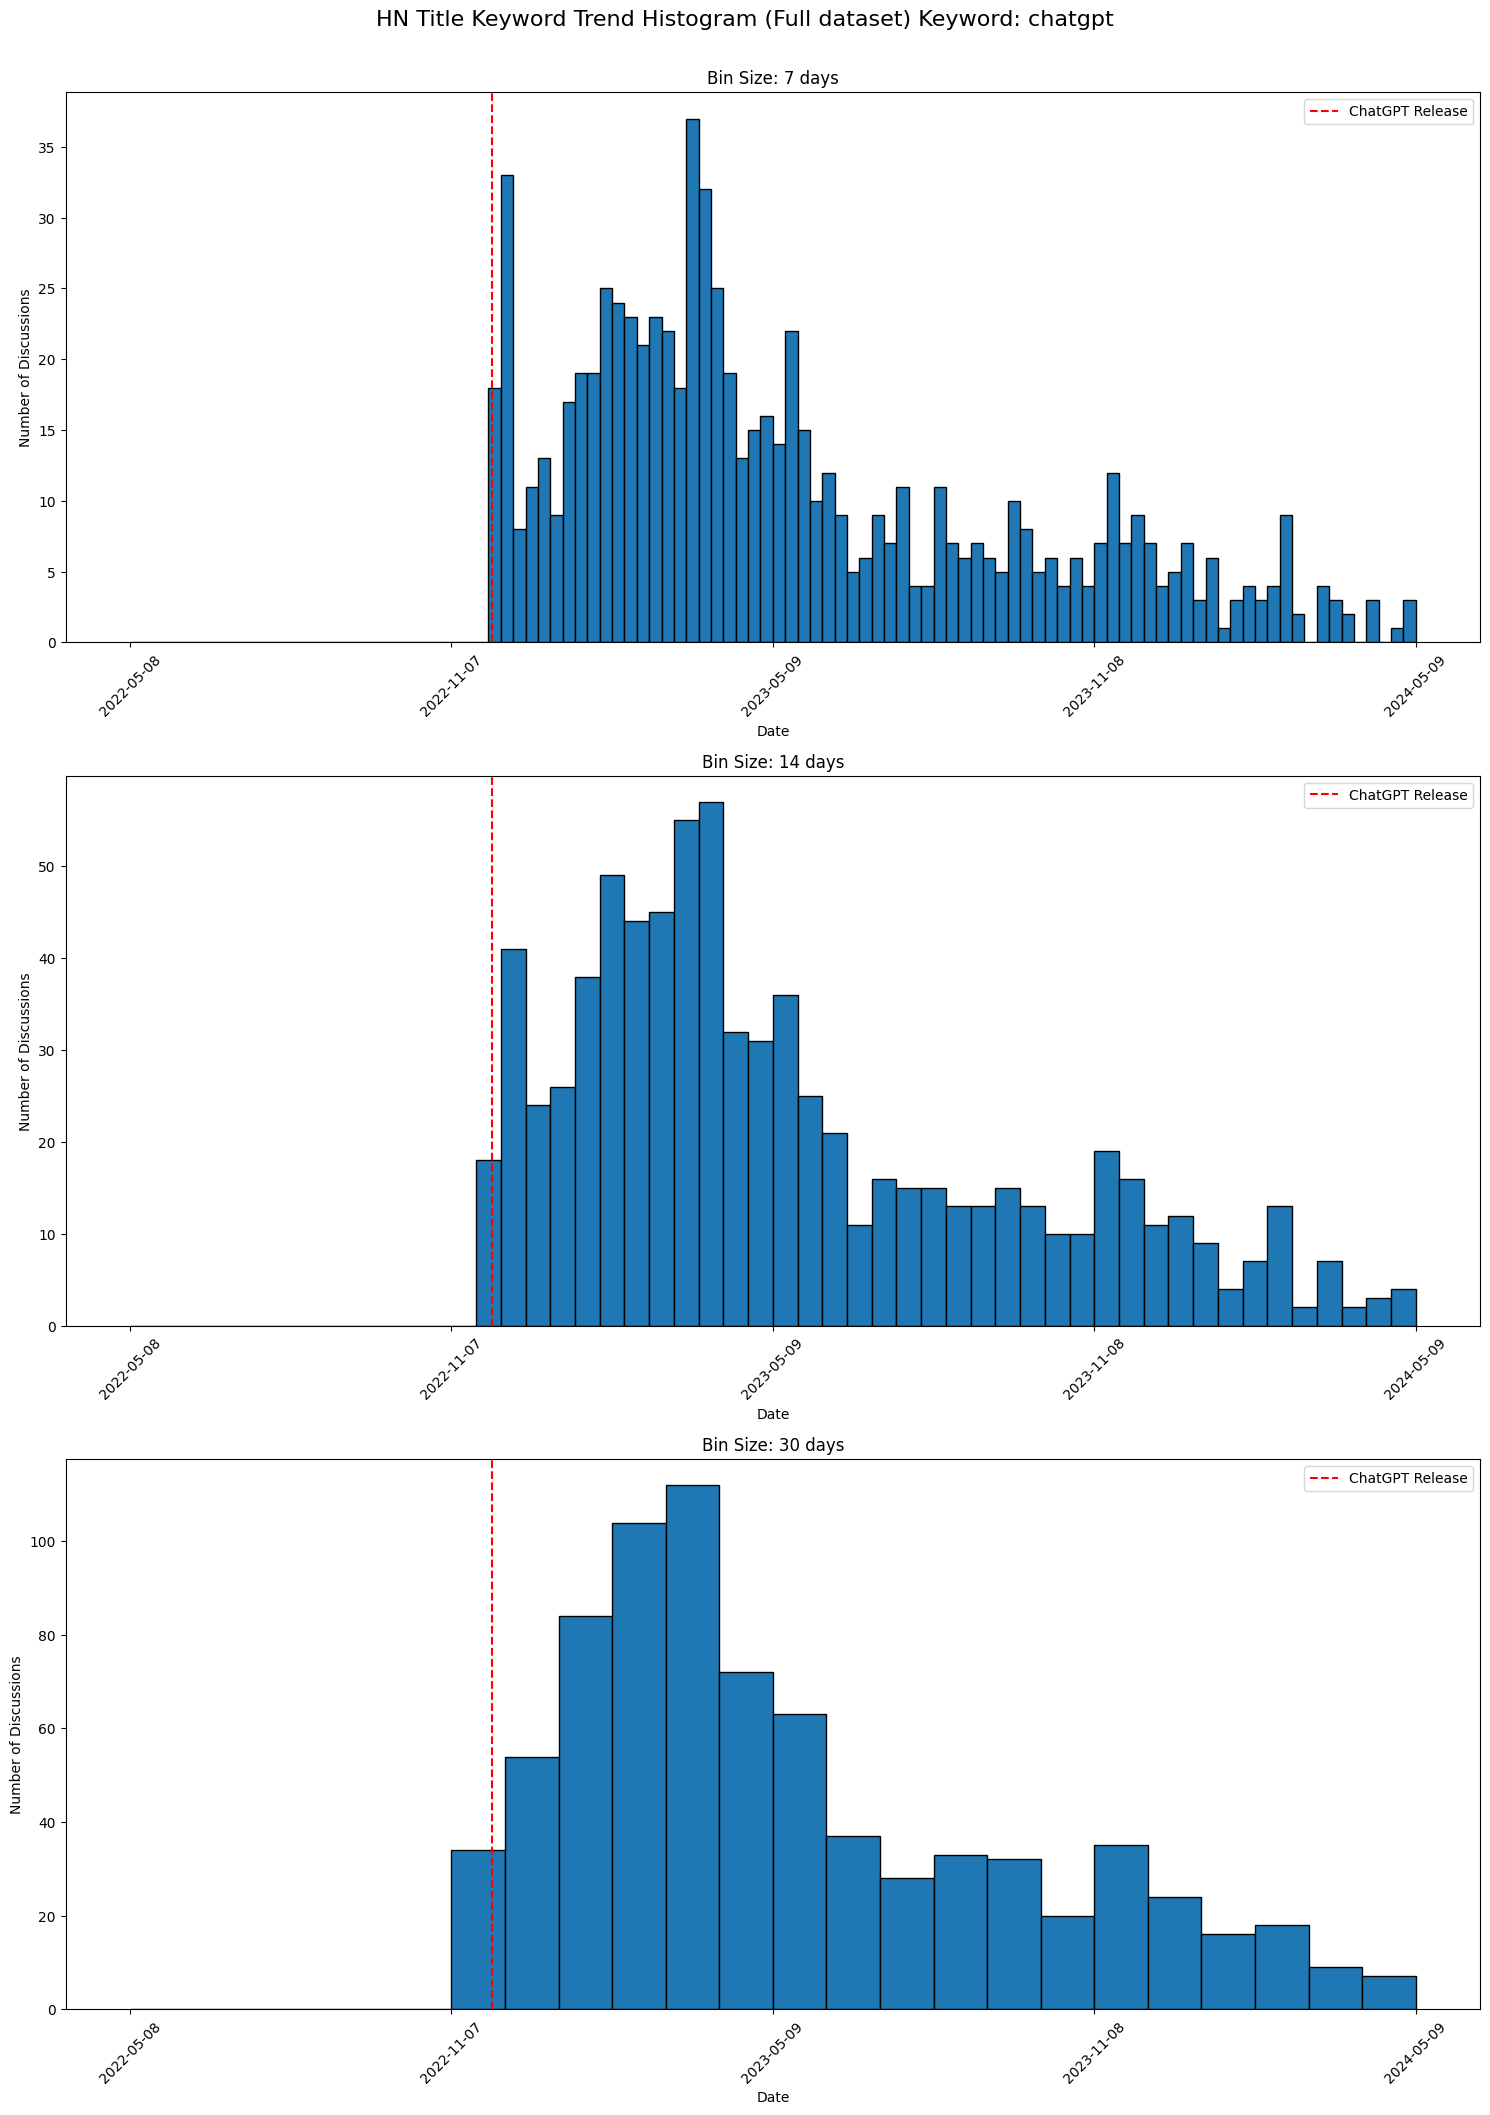

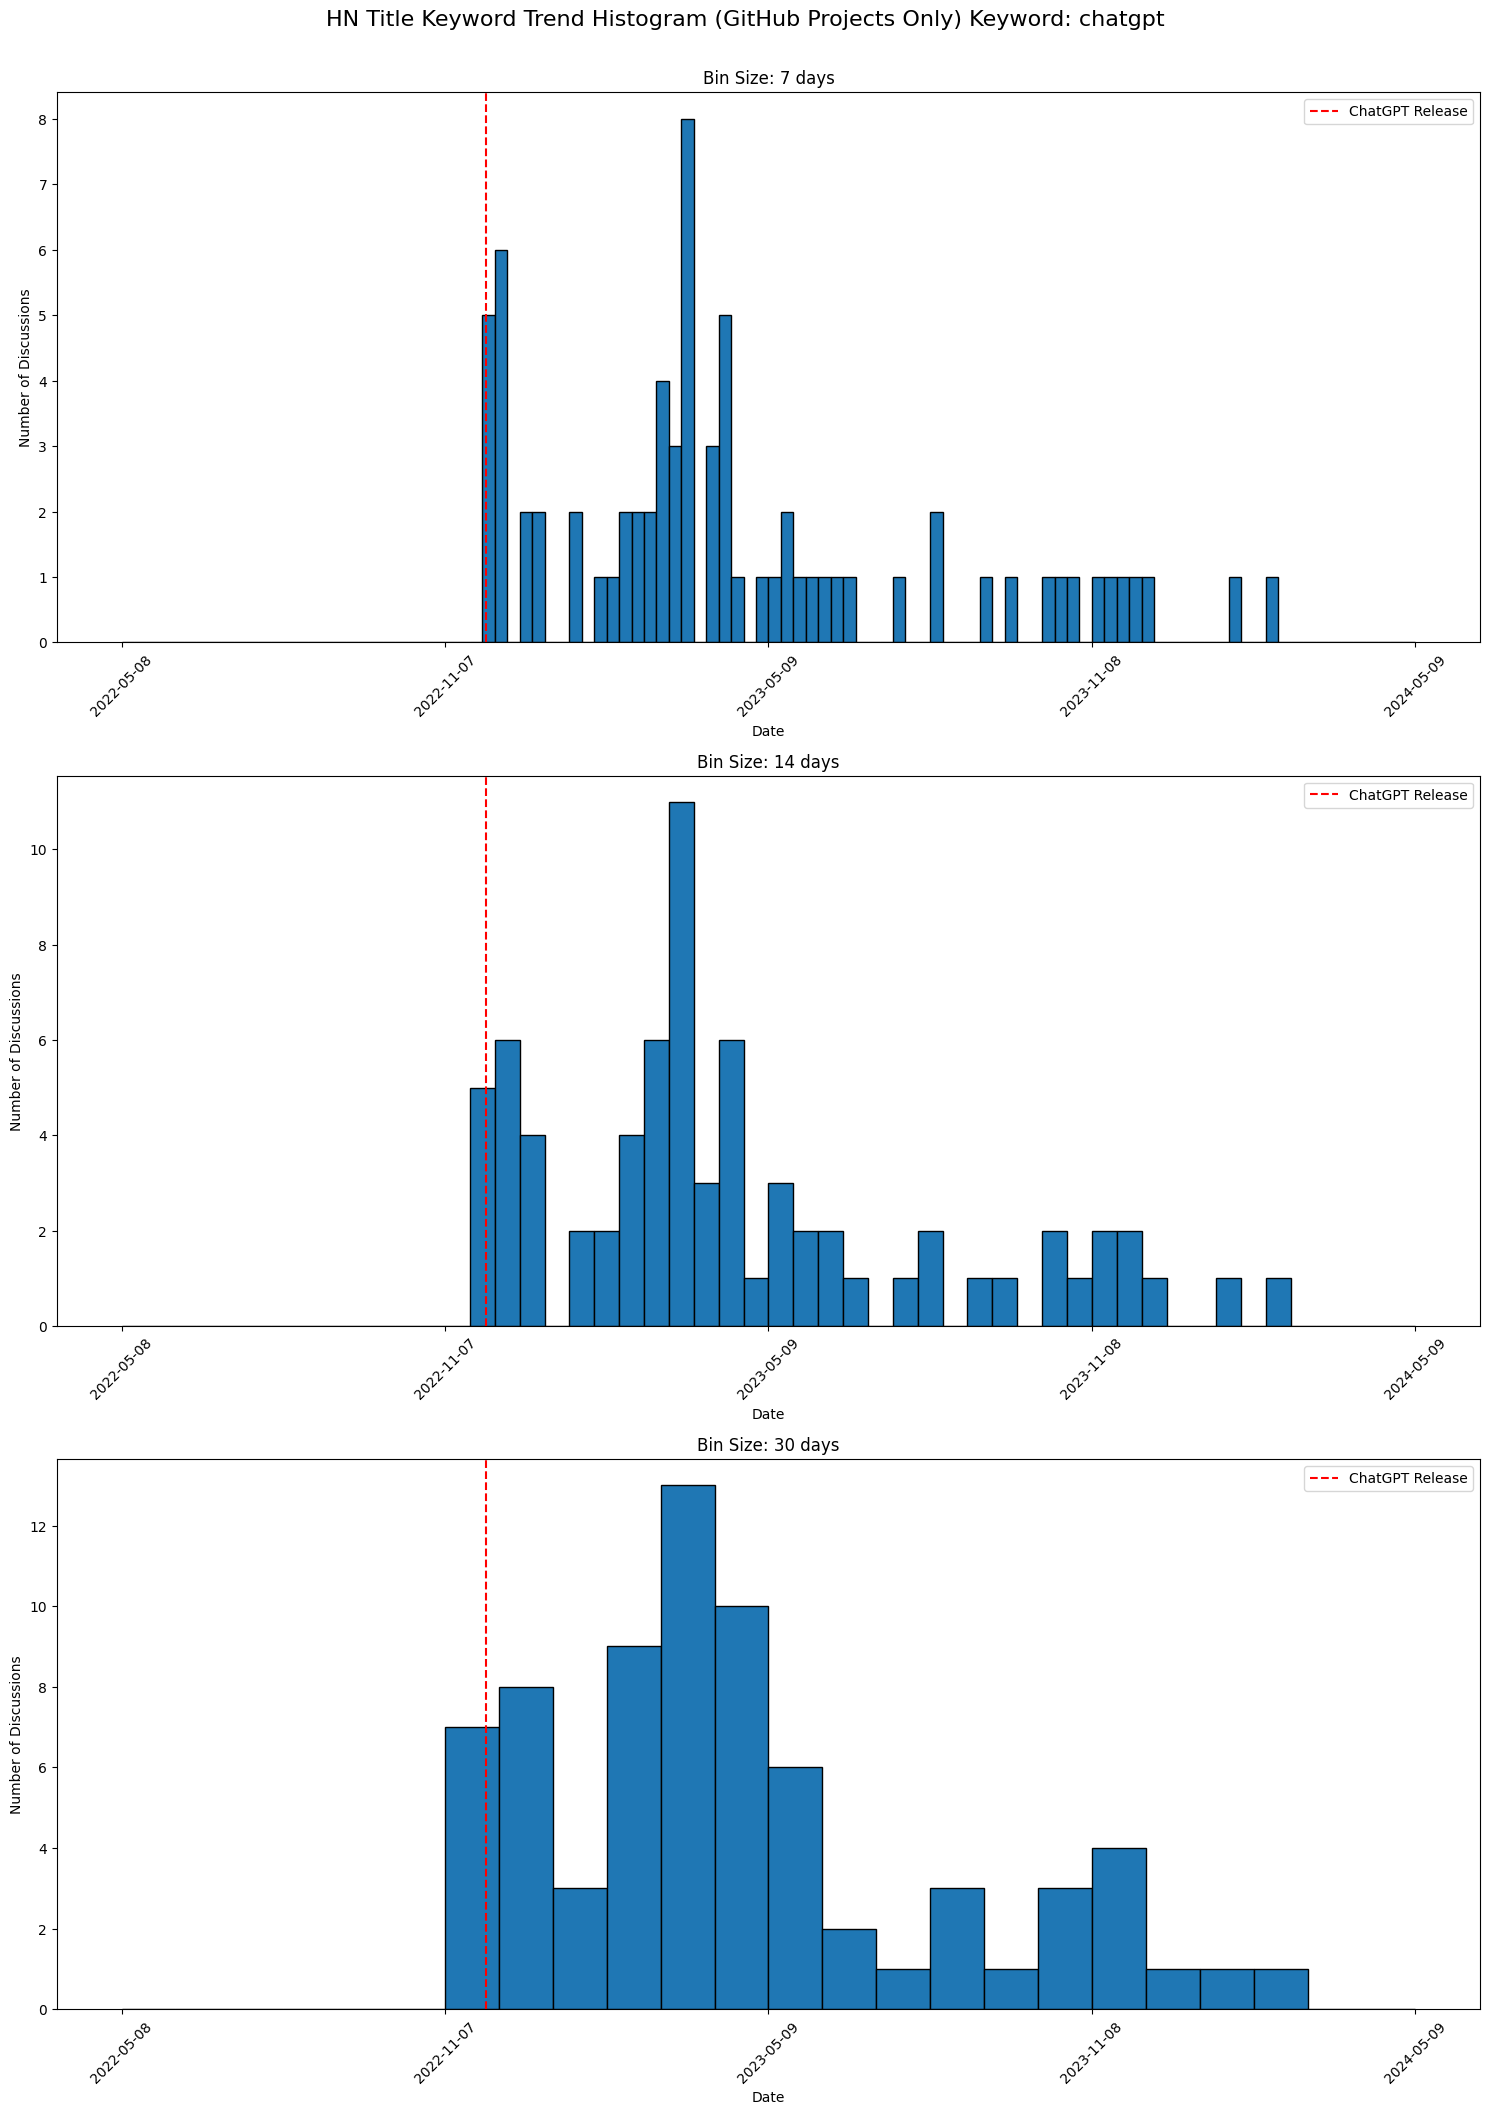

In [68]:
plot_discussions_histogram_keywords('HN Title Keyword Trend Histogram (Full dataset)', HN_STORIES_CSV, keyword='chatgpt')
plot_discussions_histogram_keywords('HN Title Keyword Trend Histogram (GitHub Projects Only)', HN_STORIES_GH_CSV, keyword='chatgpt')

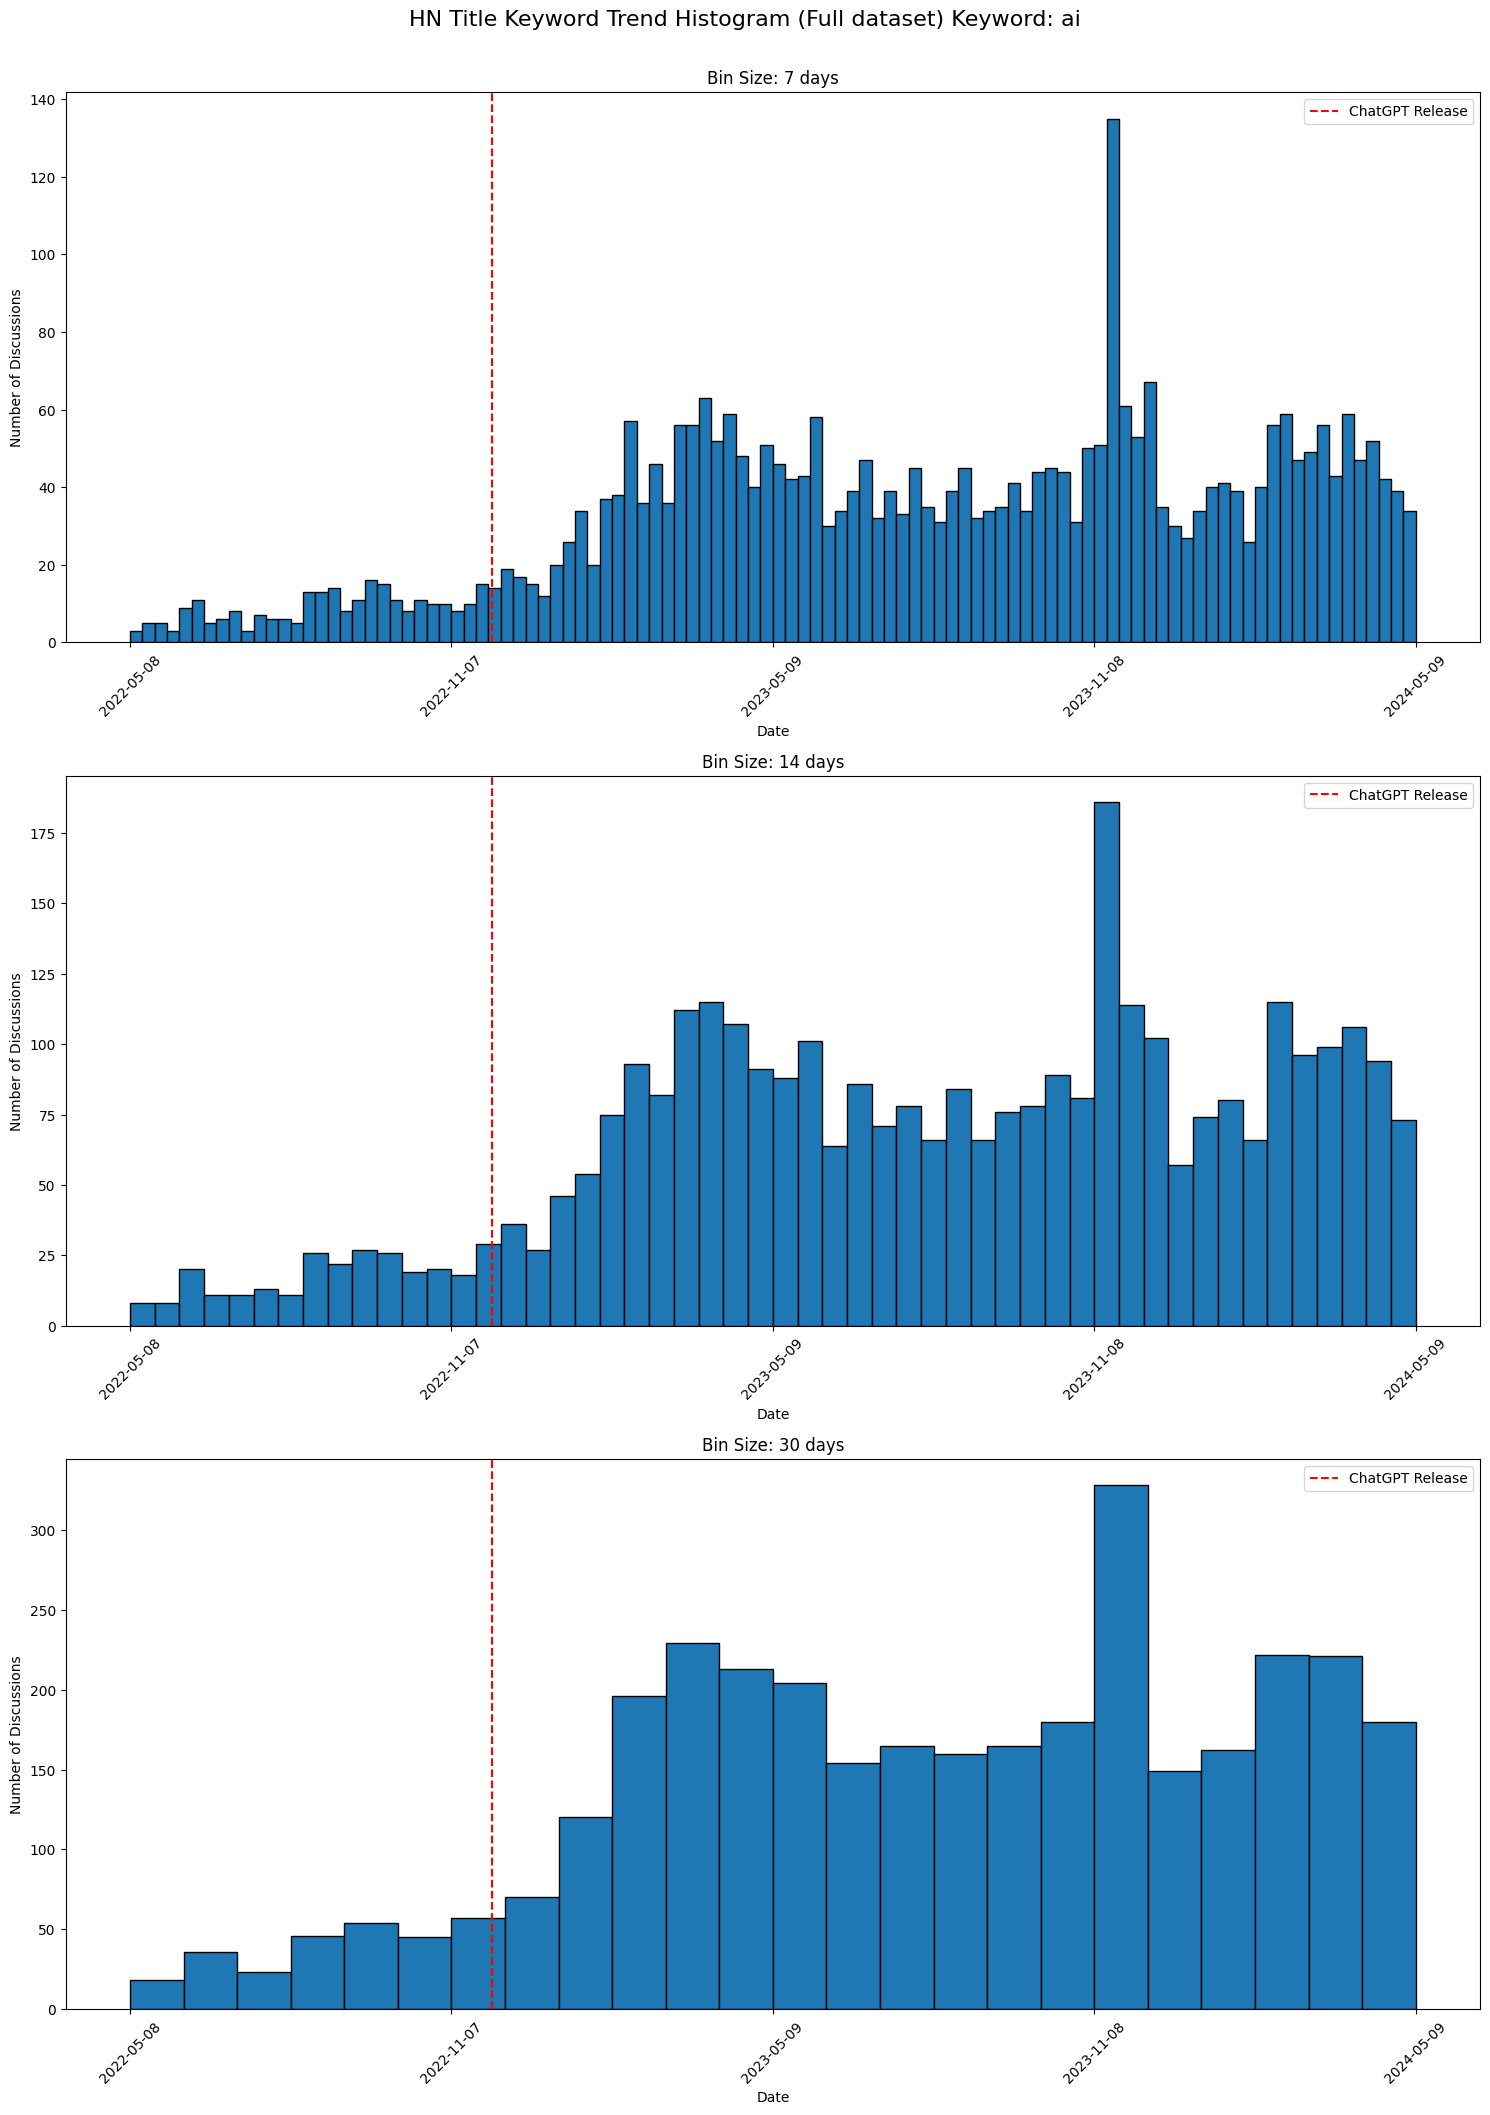

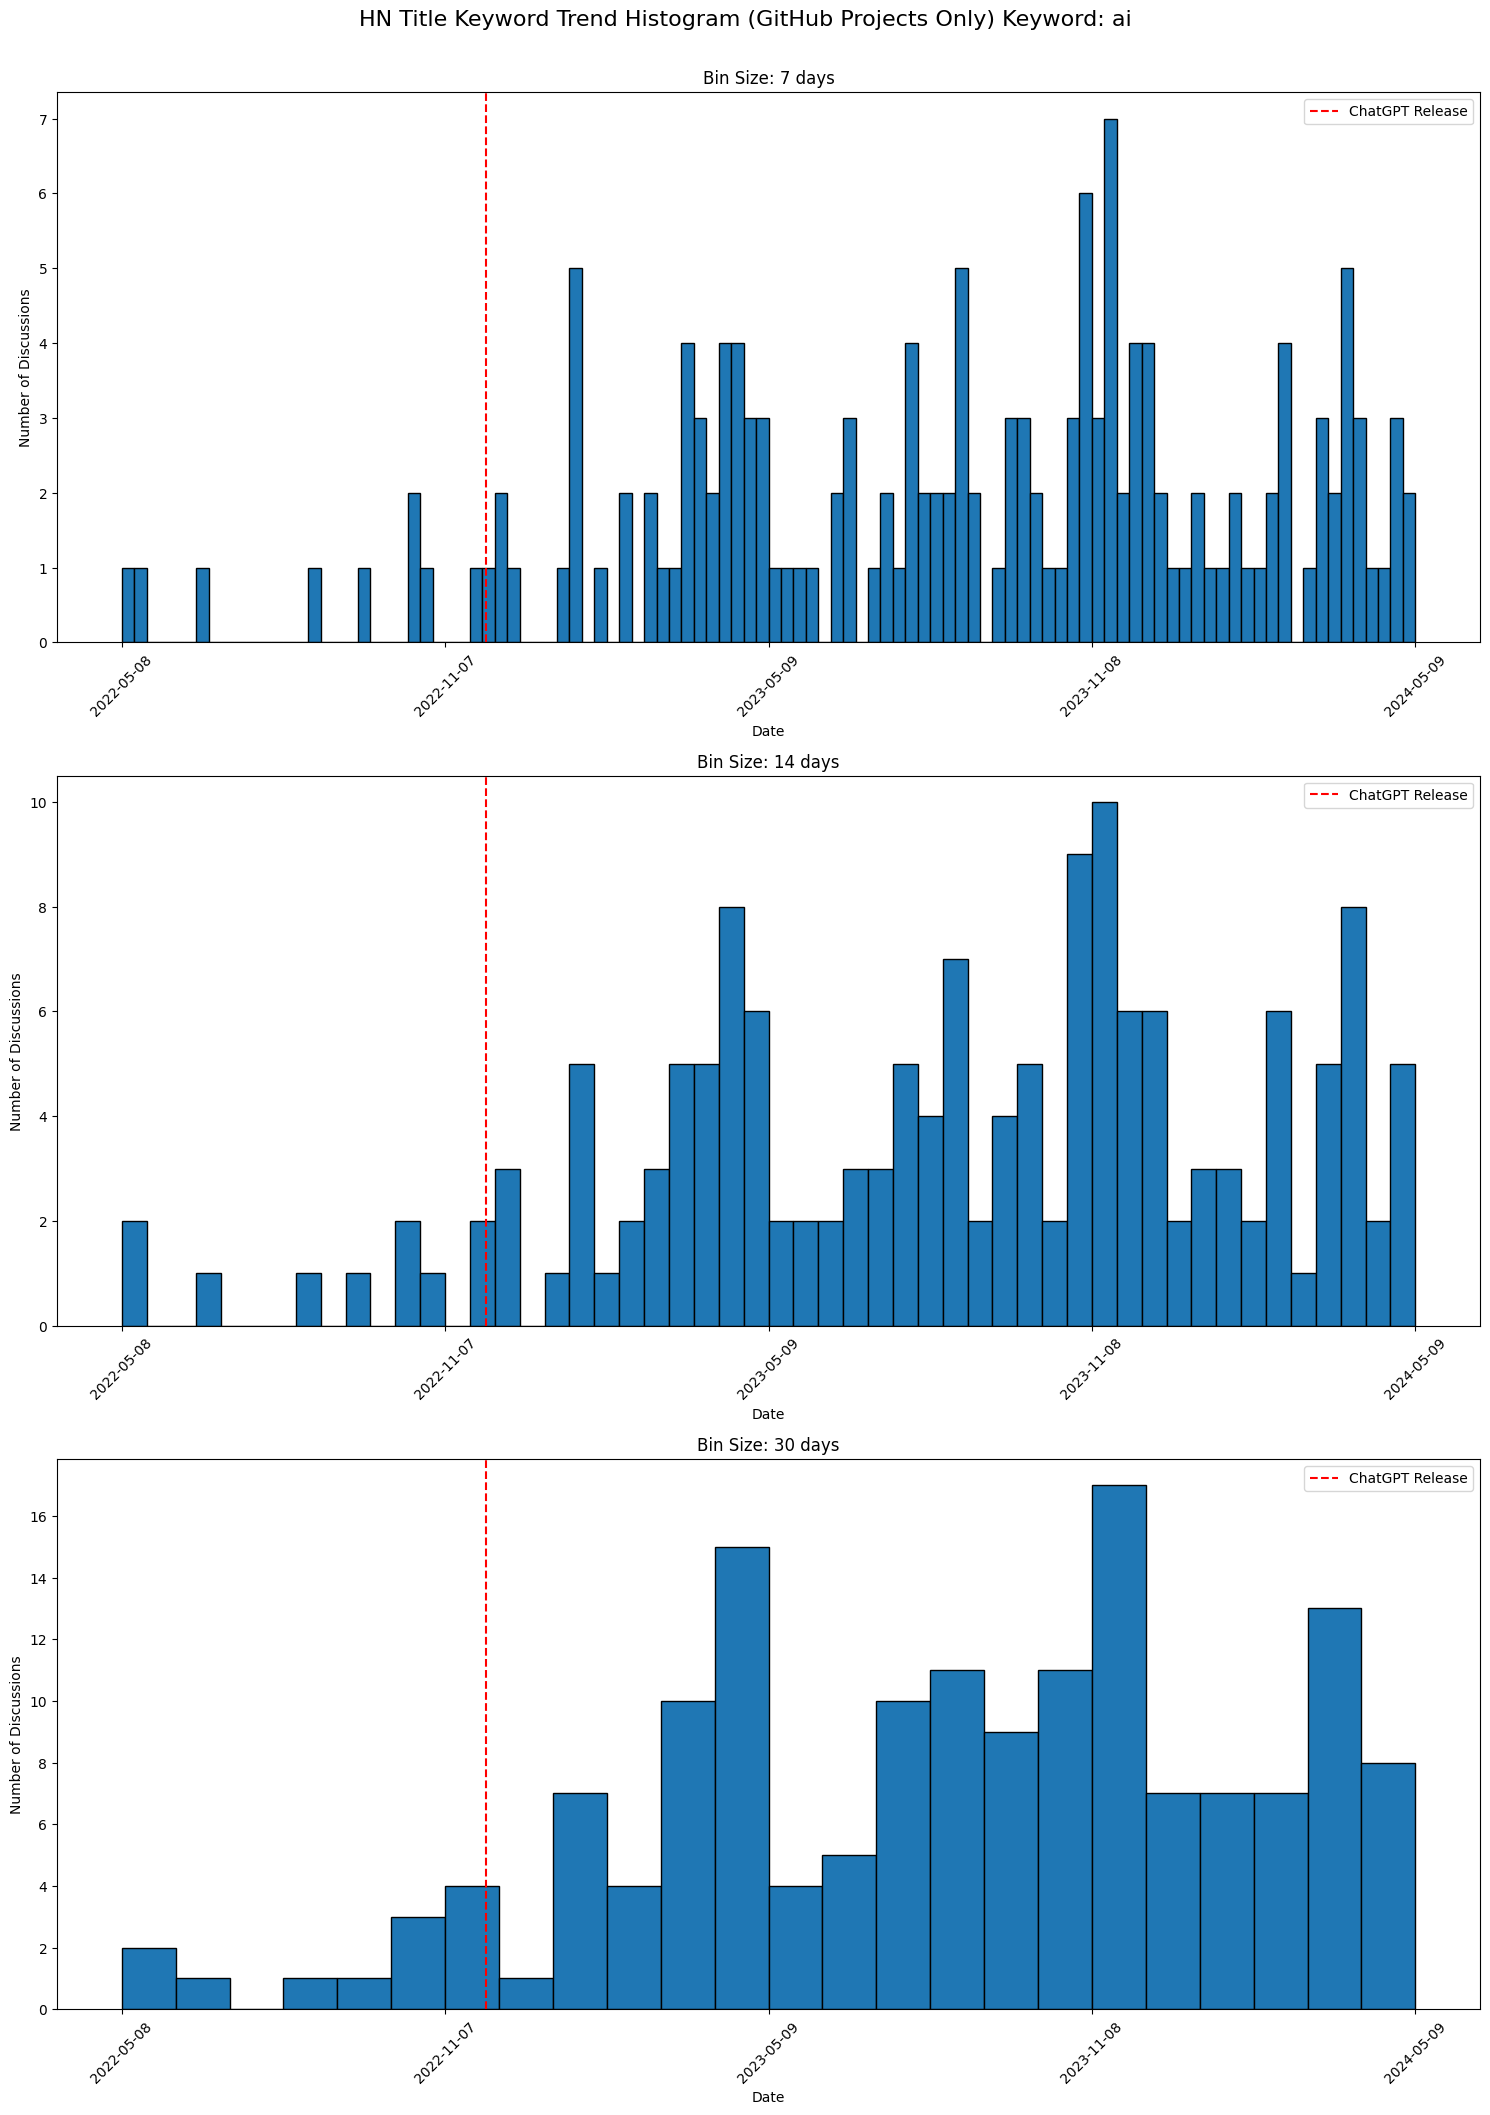

In [69]:
plot_discussions_histogram_keywords('HN Title Keyword Trend Histogram (Full dataset)', HN_STORIES_CSV, keyword='ai')
plot_discussions_histogram_keywords('HN Title Keyword Trend Histogram (GitHub Projects Only)', HN_STORIES_GH_CSV, keyword='ai')

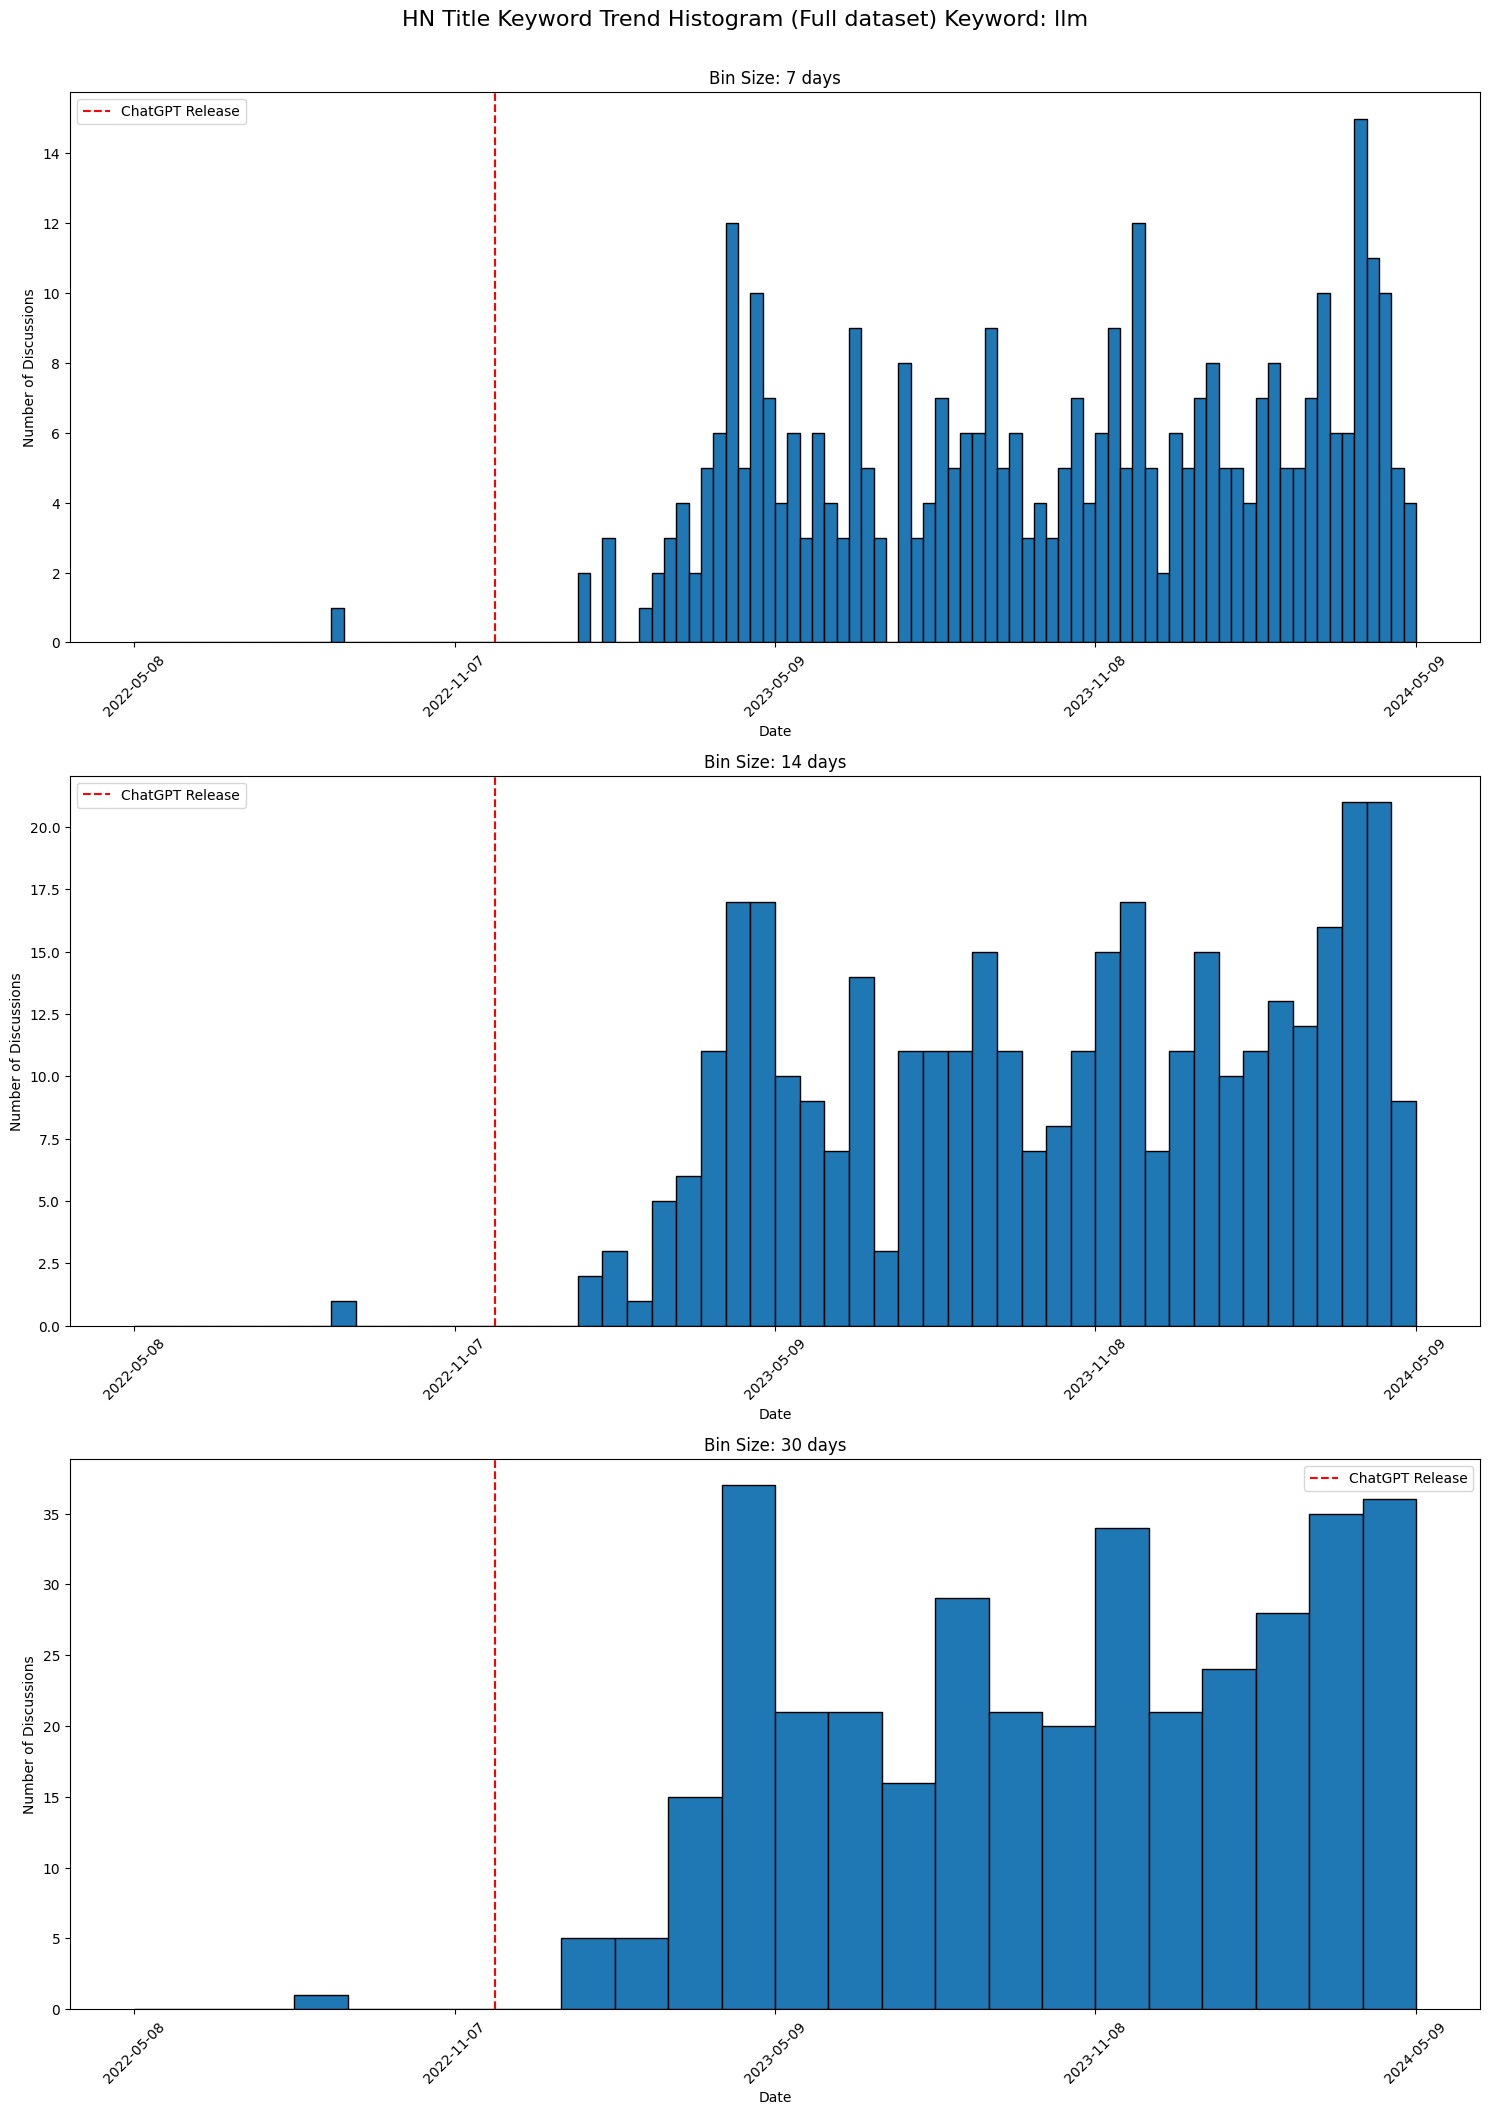

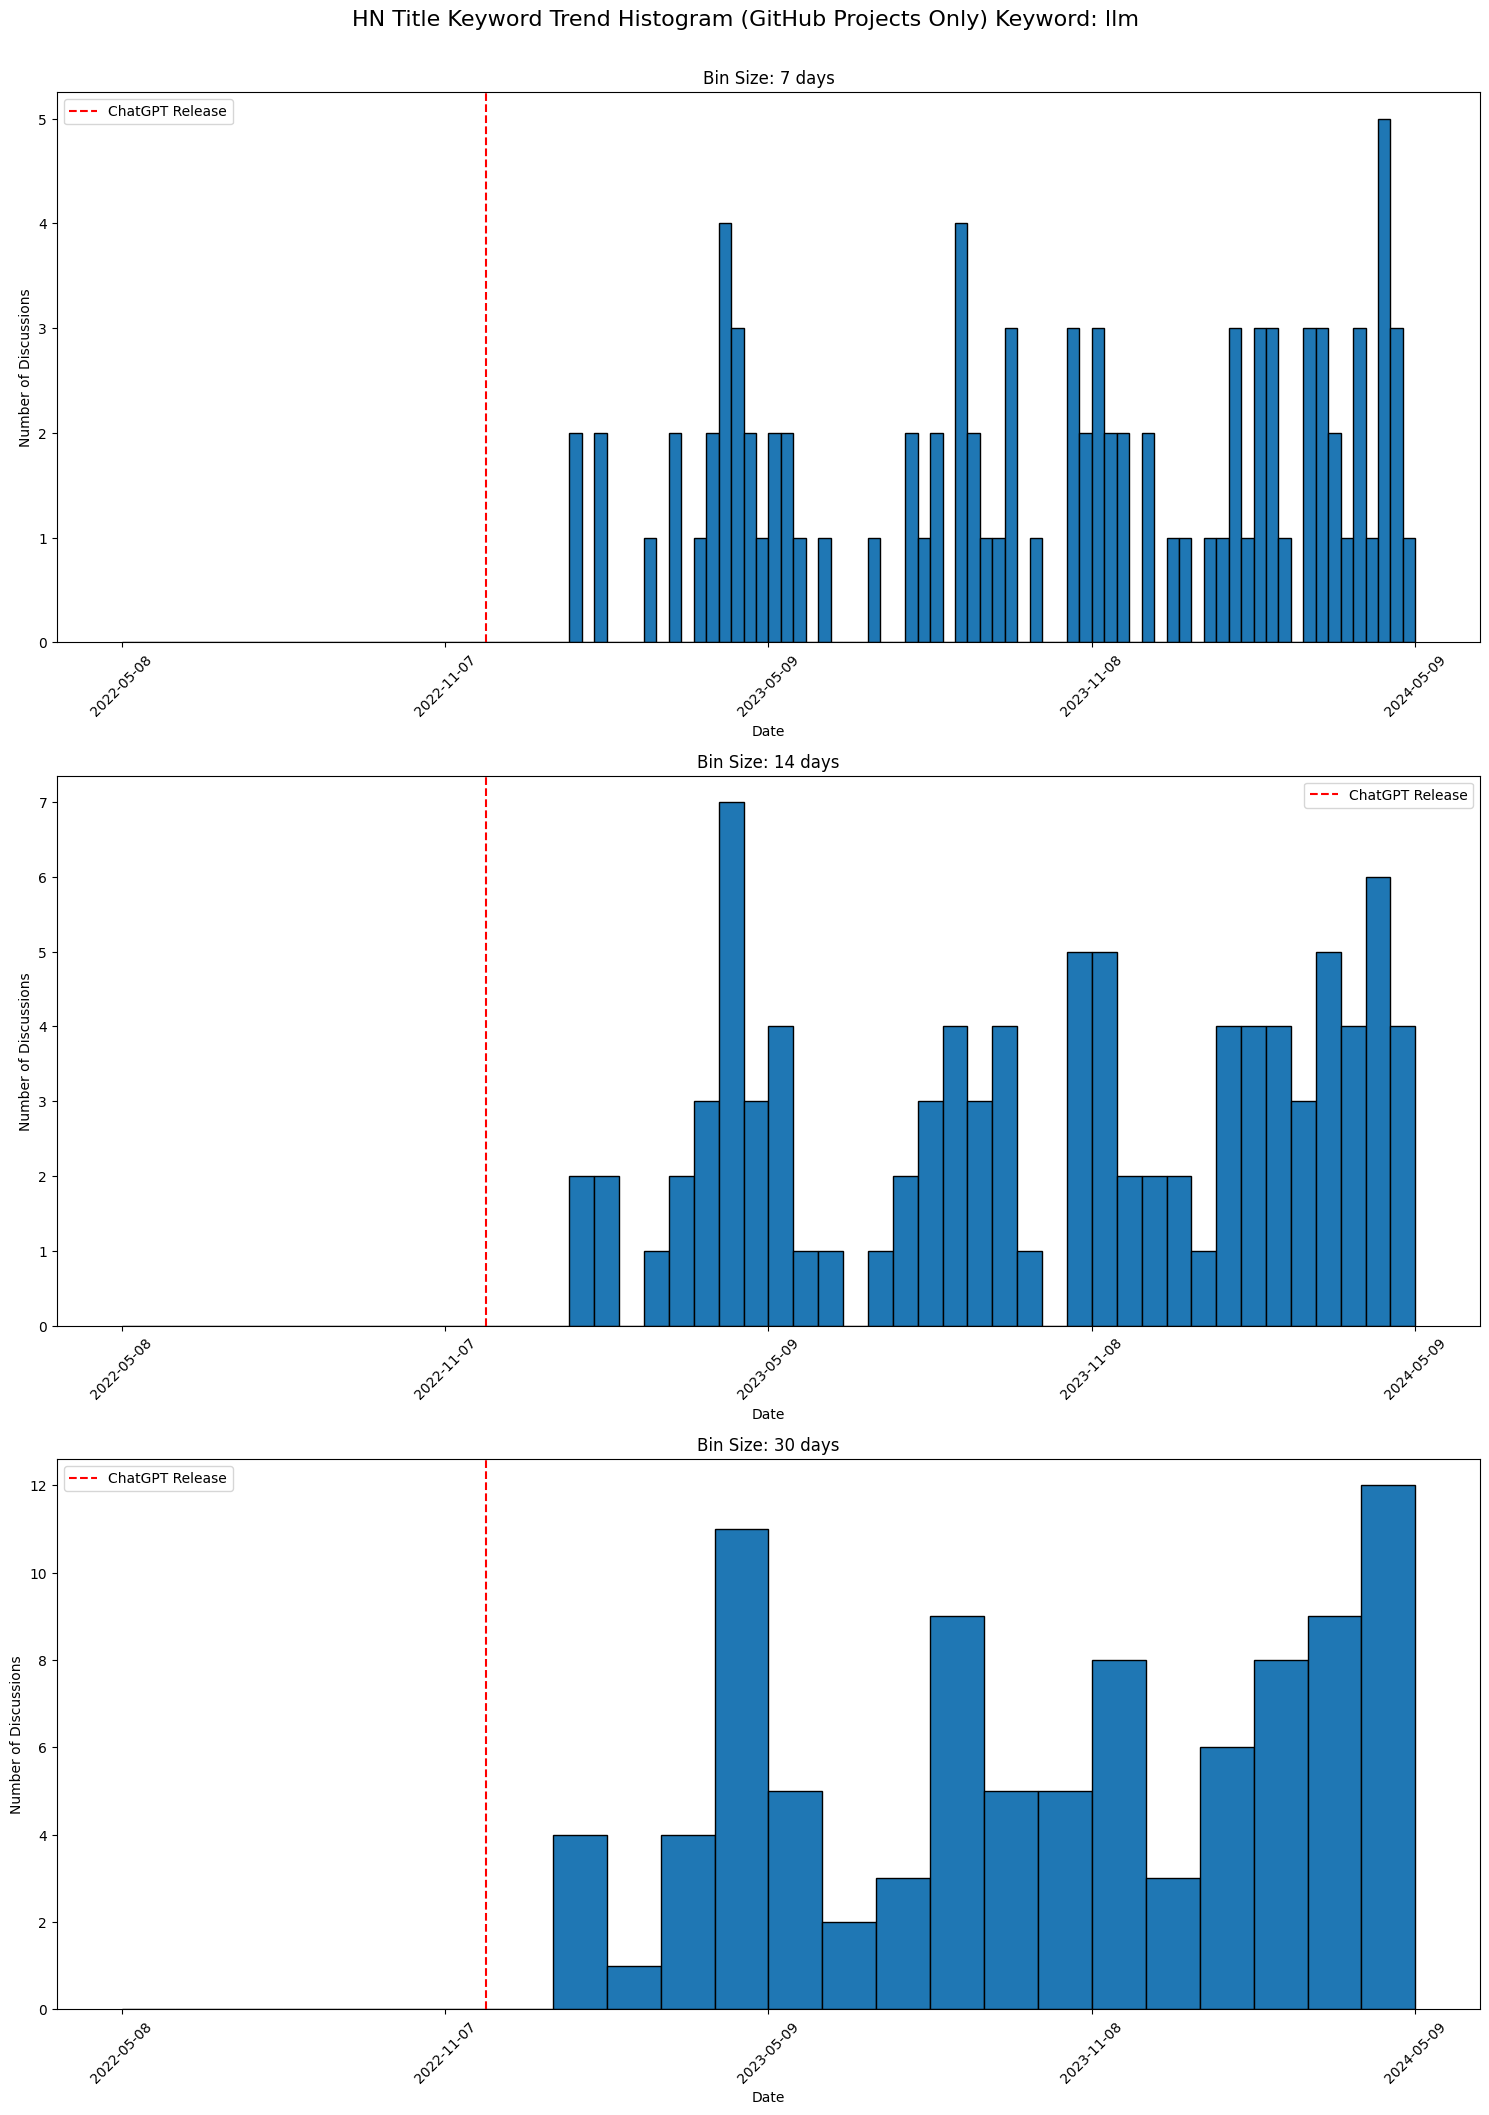

In [70]:
plot_discussions_histogram_keywords('HN Title Keyword Trend Histogram (Full dataset)', HN_STORIES_CSV, keyword='llm')
plot_discussions_histogram_keywords('HN Title Keyword Trend Histogram (GitHub Projects Only)', HN_STORIES_GH_CSV, keyword='llm')

## time series analysis

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from ruptures import Binseg
import matplotlib.dates as mdates

def perform_rq1_analyses(csv_file_path, keyword):
    # Read and preprocess the data
    df = pd.read_csv(csv_file_path)
    # df = df[df['title'].str.contains(keyword, case=False, regex=True)]
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.sort_values('date')

    # Resample to daily frequency
    daily_counts = df.set_index('date').resample('D').size().fillna(0)

    # 1. Trend Analysis
    # X = np.arange(len(daily_counts)).reshape(-1, 1)
    # y = daily_counts.values
    # linear_model = stats.linregress(X.flatten(), y)
    # print(f"Linear trend: slope={linear_model.slope:.4f}, intercept={linear_model.intercept:.4f}, r-value={linear_model.rvalue:.4f}")

    # 2. Change Point Detection
    # model = Binseg(model="l2").fit(y)
    # change_points = model.predict(n_bkps=3)
    # print(f"Detected change points: {daily_counts.index[change_points]}")

    # 3. Moving Average
    window_size = 30
    moving_avg = daily_counts.rolling(window=window_size).mean()

    # 4. Seasonality Analysis
    # Only perform if we have enough data points
    # if len(daily_counts) > 2 * 365:  # At least 2 years of data
    # result = seasonal_decompose(daily_counts, model='additive', period=350)
    # seasonal_component = result.seasonal
    # else:
    #     seasonal_component = None
    #     print("Not enough data for seasonal decomposition")

    # 5. Impact of ChatGPT Release
    chatgpt_release = pd.Timestamp('2022-11-30')
    before_chatgpt = daily_counts[daily_counts.index < chatgpt_release]
    after_chatgpt = daily_counts[daily_counts.index >= chatgpt_release]
    t_stat, p_value = stats.ttest_ind(before_chatgpt, after_chatgpt)
    print(f"T-test results: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")

    # 6. Correlation with Time
    time_values = np.arange(len(daily_counts))
    correlation = np.corrcoef(time_values, daily_counts.values)[0, 1]
    print(f"Correlation with time: {correlation:.4f}")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(30, 15))

    # Original data with trend and moving average
    ax1.plot(daily_counts.index, daily_counts.values, label='Daily Counts')
    # ax1.plot(daily_counts.index, linear_model.slope * X.flatten() + linear_model.intercept, 'r', label='Linear Trend')
    ax1.plot(daily_counts.index, moving_avg, 'g', label=f'{window_size}-day Moving Average')
    # for cp in change_points:
    #     ax1.axvline(daily_counts.index[cp], color='purple', linestyle='--')
    ax1.axvline(chatgpt_release, color='orange', linestyle='--', label='ChatGPT Release')
    ax1.set_title('AI/LLM Discussions on Hackernews Over Time')
    ax1.legend()
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Seasonal decomposition
    # if seasonal_component is not None:
    #     ax2.plot(seasonal_component)
    #     ax2.set_title('Seasonal Component')
    #     ax2.xaxis.set_major_locator(mdates.MonthLocator())
    #     ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #     plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    # else:
    #     ax2.text(0.5, 0.5, 'Not enough data for seasonal decomposition',
    #              horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()


T-test results: t-statistic=-9.3618, p-value=0.0000
Correlation with time: 0.2604


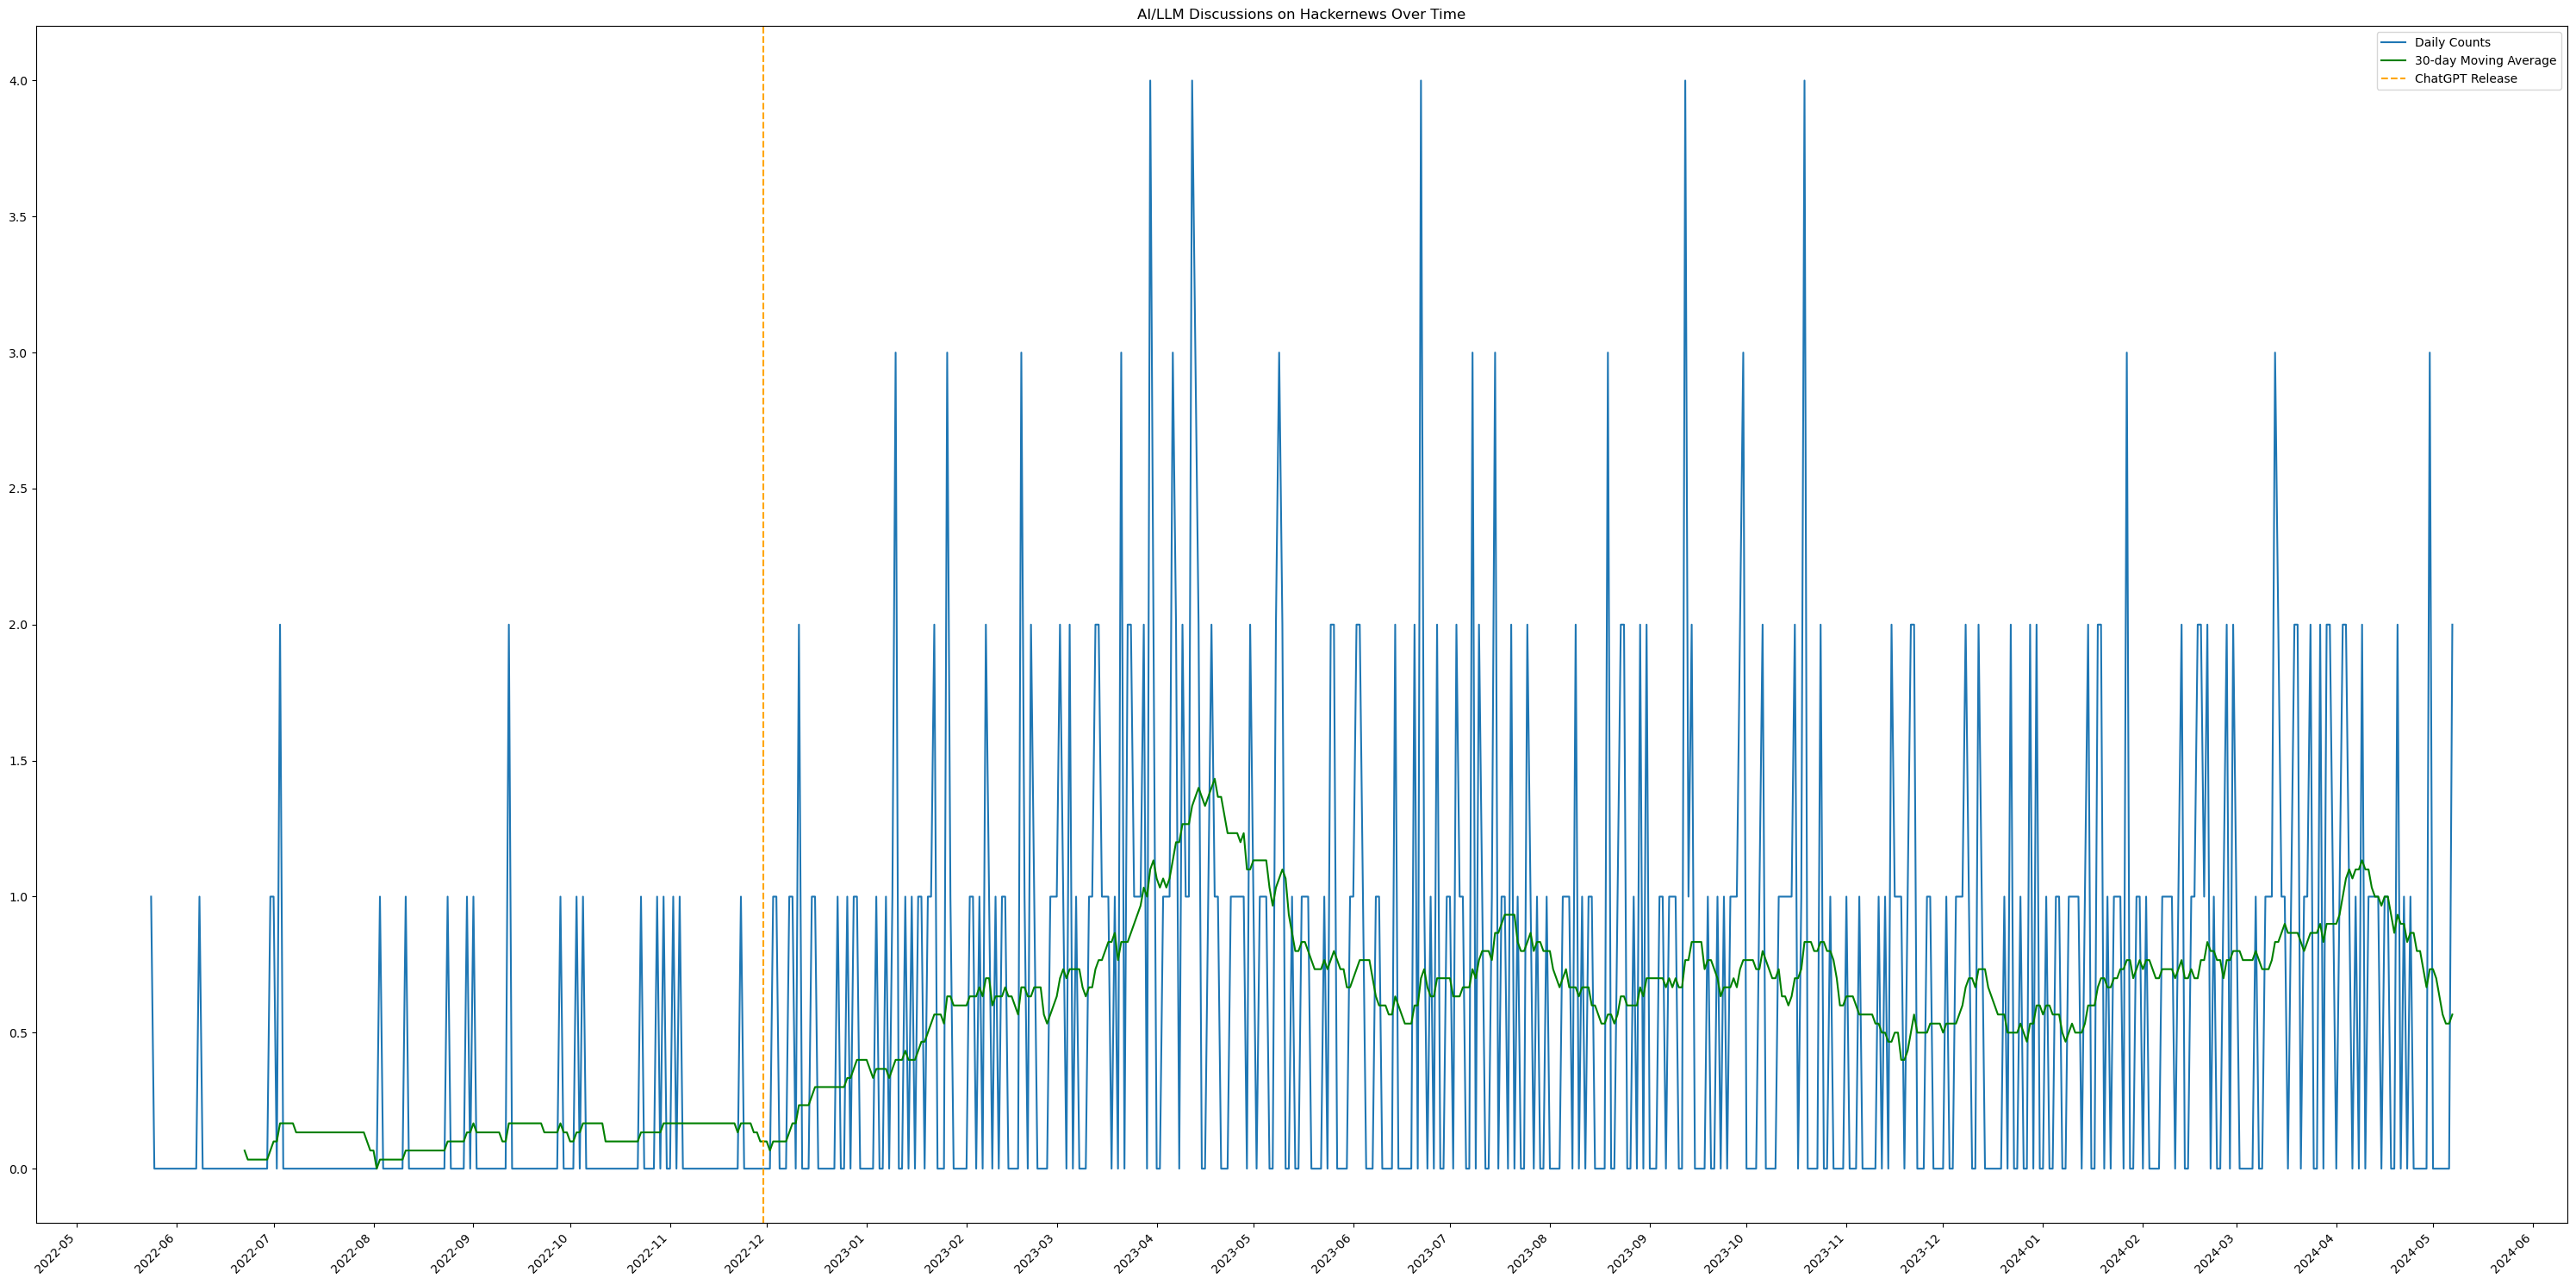

In [ ]:
csv_file_path = './dataset_raw.csv'
keyword = 'ai'
perform_rq1_analyses(csv_file_path=csv_file_path, keyword=keyword)